# DHV Assignment Solution

## General Setup

In [229]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [230]:
# Import packages
import pyarrow as pa
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import table 

import pycountry
import pycountry_convert as pc

import geopandas

In [231]:
sns.set_style("whitegrid")

In [232]:
LARGE_FIGSIZE = (20, 15)
SMALL_FIGSIZE = (15, 10)

## Load Dataset

Dataset: https://www.kaggle.com/datasets/saurabhbadole/countries-in-conflict-dataset

World Countries ShapeFile: https://www.naturalearthdata.com/downloads/110m-cultural-vectors/

Map-plotting algorithm: https://geopandas.org/en/stable/gallery/choropleths.html

This dataset covers events from `1989 - 2022`.
It doesn't include major conflicts such as 
    - World War I (1914-1918): Also known as the Great War, it was a global conflict primarily centered in Europe. It involved many of the world's great powers, divided into two opposing alliances: the Allies (led by France, Russia, and the United Kingdom) and the Central Powers (led by Germany, Austria-Hungary, and the Ottoman Empire).

    - Spanish Civil War (1936-1939): A conflict fought between the Republicans, who were loyal to the democratically elected Spanish Republic, and the Nationalists, a fascist rebel group led by General Francisco Franco. The Nationalists ultimately prevailed, leading to Franco's dictatorship in Spain until his death in 1975.

    - World War II (1939-1945): Another global conflict, involving many of the world's nations, fought between two major alliances: the Allies (including the United States, the Soviet Union, the United Kingdom, and China) and the Axis powers (primarily Nazi Germany, Italy, and Japan).

     - Korean War (1950-1953): Fought between North Korea, supported by China and the Soviet Union, and South Korea, supported by the United Nations, primarily the United States. The war ended in an armistice, but a formal peace treaty was never signed, leaving the Korean Peninsula divided to this day.

     - Vietnam War (1955-1975): A conflict between North Vietnam, supported by its communist allies, and South Vietnam, backed by the United States and other anti-communist nations. The war ended with the fall of Saigon and the reunification of Vietnam under communist rule.

     - Six-Day War (1967): A brief but significant conflict between Israel and the neighboring states of Egypt, Jordan, and Syria. Israel emerged victorious and gained control of the Gaza Strip, the Sinai Peninsula, the West Bank, and the Golan Heights.

     - Iran-Iraq War (1980-1988): Fought between Iran and Iraq, this was one of the longest and deadliest conventional wars of the 20th century. It began with Iraq's invasion of Iran and ended in a stalemate, with neither side achieving significant territorial gains.

     or more recent conflicts such as:
    
    - Russia's Invasion of Ukraine (2022 - present)
    - Yemeni Civil War (2014 - present)
    - Myanmar Civil War (1948 - present)
    - Sudan Conflict (2023 - present)


### Questions to answer (Ideas)
 - Which country has been involved in the most conflicts?
 - Which continent has been involved in the most conflicts?
 - Which continent has seen the least?
 - Overall time plot of deaths and years
 - Are African conflicts getting scarier? Even while European wars are getting 'safer'?
 - If true, what is promoting the increased violence in Africa?
     - They are newer states perhaps?
     - Funding from other sources?
 - Make a geographic plot of countries and the number of total conflicts they've had as overlay
 - Are more African deaths due to a larger population?


In [233]:
dataset = pd.read_csv("./countries-in-conflict-data.csv")
dataset.rename(
    columns={
        "Deaths in ongoing conflicts in a country (best estimate) - Conflict type: all": "Deaths"
    },
    inplace=True,
)

In [234]:
dataset.sample(50)

,Country,Country Abbreviation,Year,Deaths
5271,Sao Tome and Principe,STP,1990,0
982,Burundi,BDI,2019,75
2874,Iraq,IRQ,2007,4489
4435,Niger,NER,2004,4
3971,Micronesia (country),FSM,2016,0
5631,Somalia,SOM,2010,2817
205,Antigua and Barbuda,ATG,1990,0
4807,Paraguay,PRY,2002,0
4697,Palestine,PSE,1994,47
6610,Uzbekistan,UZB,2003,0


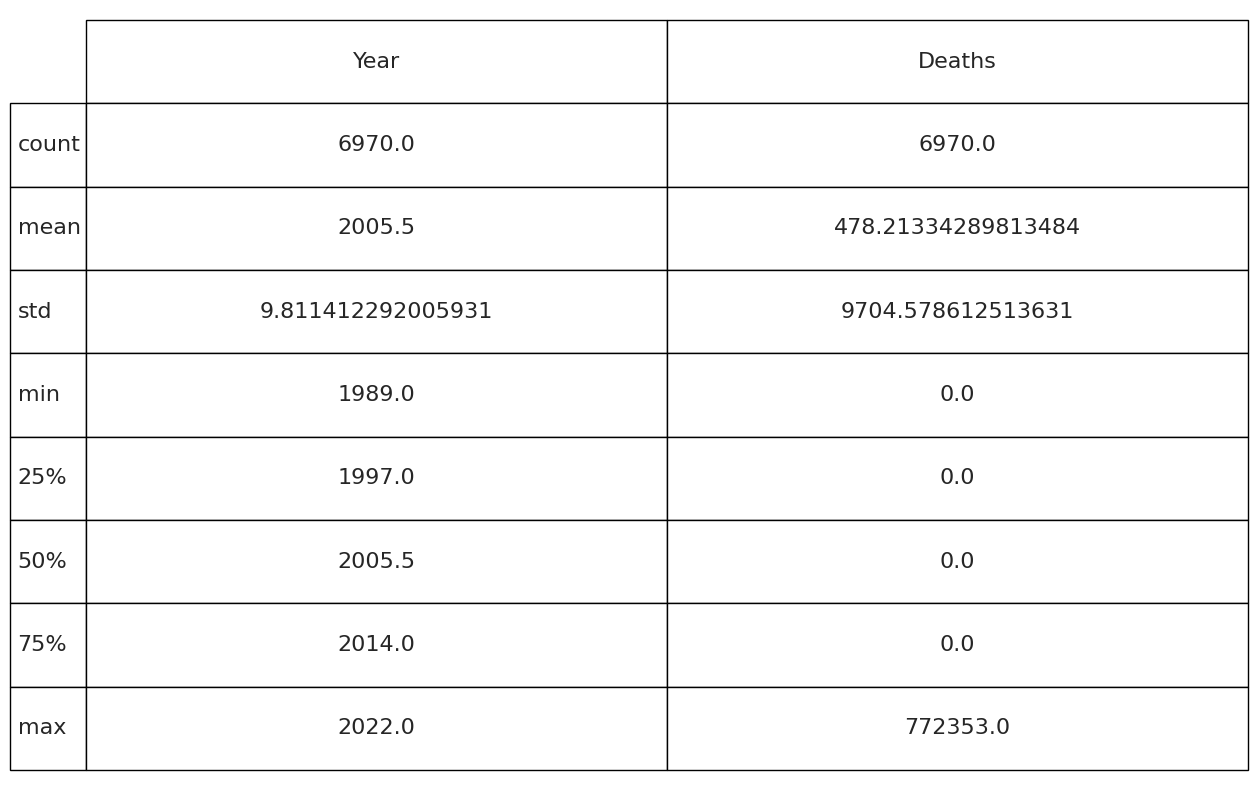

In [235]:

fix, ax = plt.subplots(figsize=SMALL_FIGSIZE)
t = table(ax, data=dataset.describe(), loc='center', cellLoc='center')
t.set_fontsize(16)
t.scale(1,5)

plt.axis('off')
plt.savefig('figures/Dataset - Describe.png')

## Feature Engineering

In [236]:
def get_continent(x: str):
    """
    Get the continent of a country from it's name
    """
    # The pycountry package failed to retrieve the continent information for the following countries
    # So we supply it manually. Most of these countries have ceased to exist
    _countries = {
        "Cape Verde": "Africa",
        "Czechoslovakia": "Europe",
        "Democratic Republic of Congo": "Africa",
        "East Germany": "Europe",
        "East Timor": "Asia",
        "Micronesia (country)": "Oceania",
        "South Ossetia": "Asia",
        "Turkey": "Asia",
        "West Germany": "Europe",
        "Western Sahara": "Africa",
        "Yemen People's Republic": "Asia",
        "Yugoslavia": "Europe",
    }
    try:
        if continent := _countries.get(x, None):
            return continent
        result = pycountry.countries.search_fuzzy(x)
        country = result[0]
        country_alpha2 = country.alpha_2
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(
            country_continent_code
        )
        # print(country_continent_code, country_continent_name)
        return country_continent_name

    except Exception as e:  # Lookup error for 'non-existent' country
        print(e)
        pass

In [237]:
dataset["Continent"] = dataset["Country"].apply(get_continent)

SubdivisionHierarchy(code='GE-AB', country_code='GE', name='Abkhazia', parent_code=None, type='Autonomous republic')
SubdivisionHierarchy(code='GE-AB', country_code='GE', name='Abkhazia', parent_code=None, type='Autonomous republic')
SubdivisionHierarchy(code='GE-AB', country_code='GE', name='Abkhazia', parent_code=None, type='Autonomous republic')
SubdivisionHierarchy(code='GE-AB', country_code='GE', name='Abkhazia', parent_code=None, type='Autonomous republic')
SubdivisionHierarchy(code='GE-AB', country_code='GE', name='Abkhazia', parent_code=None, type='Autonomous republic')
SubdivisionHierarchy(code='GE-AB', country_code='GE', name='Abkhazia', parent_code=None, type='Autonomous republic')
SubdivisionHierarchy(code='GE-AB', country_code='GE', name='Abkhazia', parent_code=None, type='Autonomous republic')
SubdivisionHierarchy(code='GE-AB', country_code='GE', name='Abkhazia', parent_code=None, type='Autonomous republic')
SubdivisionHierarchy(code='GE-AB', country_code='GE', name='Abkh

## Dataset Visualization

In [238]:
def plot_distribution_of_casualties():
    plt.figure(figsize=LARGE_FIGSIZE)
    plt.title("Trend of Casualties in Countries globally $(1989 - 2022)$", fontsize=18)
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Deaths', fontsize=16)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    sns.lineplot(dataset, x="Year", y="Deaths")

    plt.savefig('figures/Line Plot - Casualties Globally.png')

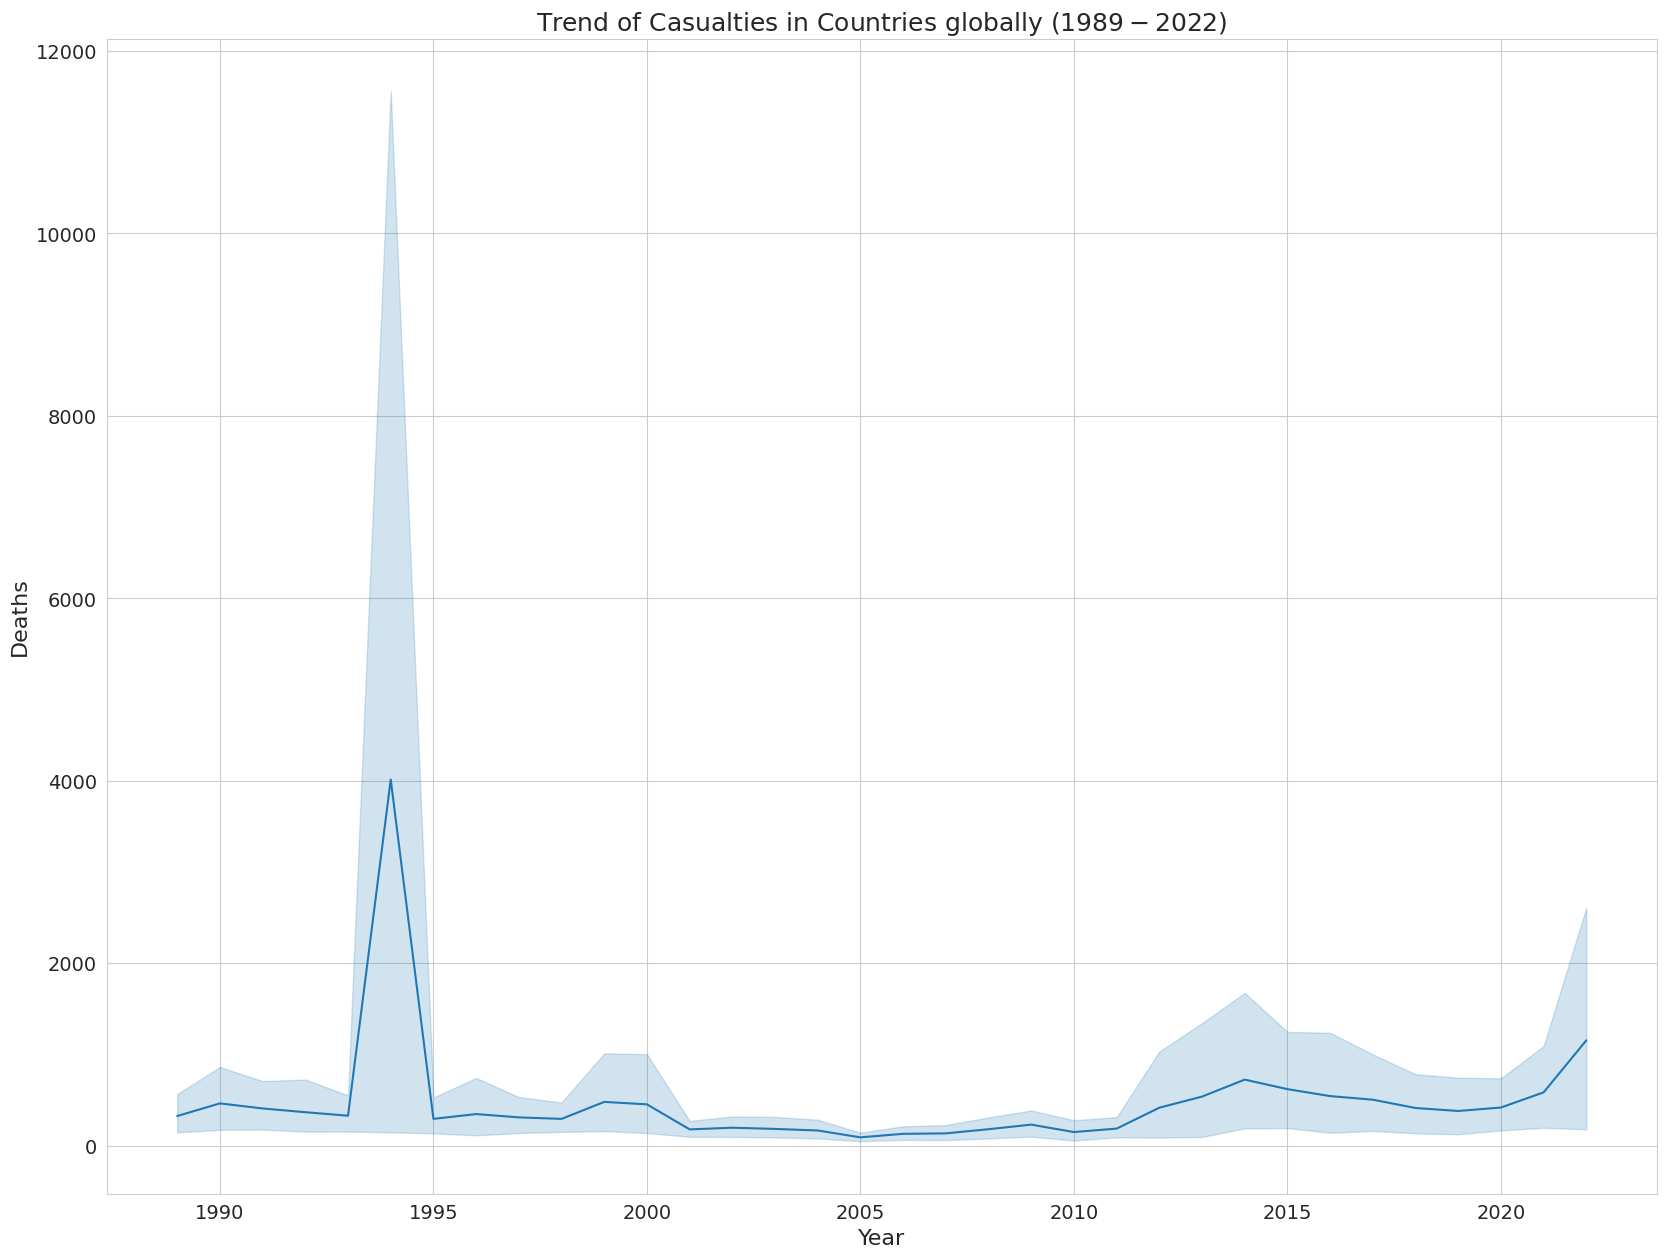

In [239]:
plot_distribution_of_casualties()

In [286]:
def plot_distribution_of_casualties_by_continent():
    """
    This function creates a line plot to visualize the distribution of casualties
    across continents over the years in the provided dataset.

    Rwanda is omitted from this plot because of it's significant outlier,
    which obscures the overall trend for Africa.
    """
    plt.figure(figsize=LARGE_FIGSIZE)
    plt.title("Casualties in Continents due to Conflicts $(1989 - 2022)$", fontsize=20)
    plt.xlabel(None, fontsize=16)
    
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # Plot continent trends
    without_rwanda = dataset[dataset["Country"] != "Rwanda"]
    continent_gp = without_rwanda.groupby("Continent").groups
    for group_name in continent_gp:
        group = dataset.iloc[continent_gp[group_name], :]
        year_trend = group.groupby("Year")["Deaths"].sum().to_dict()
        sns.lineplot(x=year_trend.keys(), y=year_trend.values(), label=group_name)

    plt.legend(fontsize=20)
    plt.savefig('figures/Line Plot - Casualties by Continent.png')

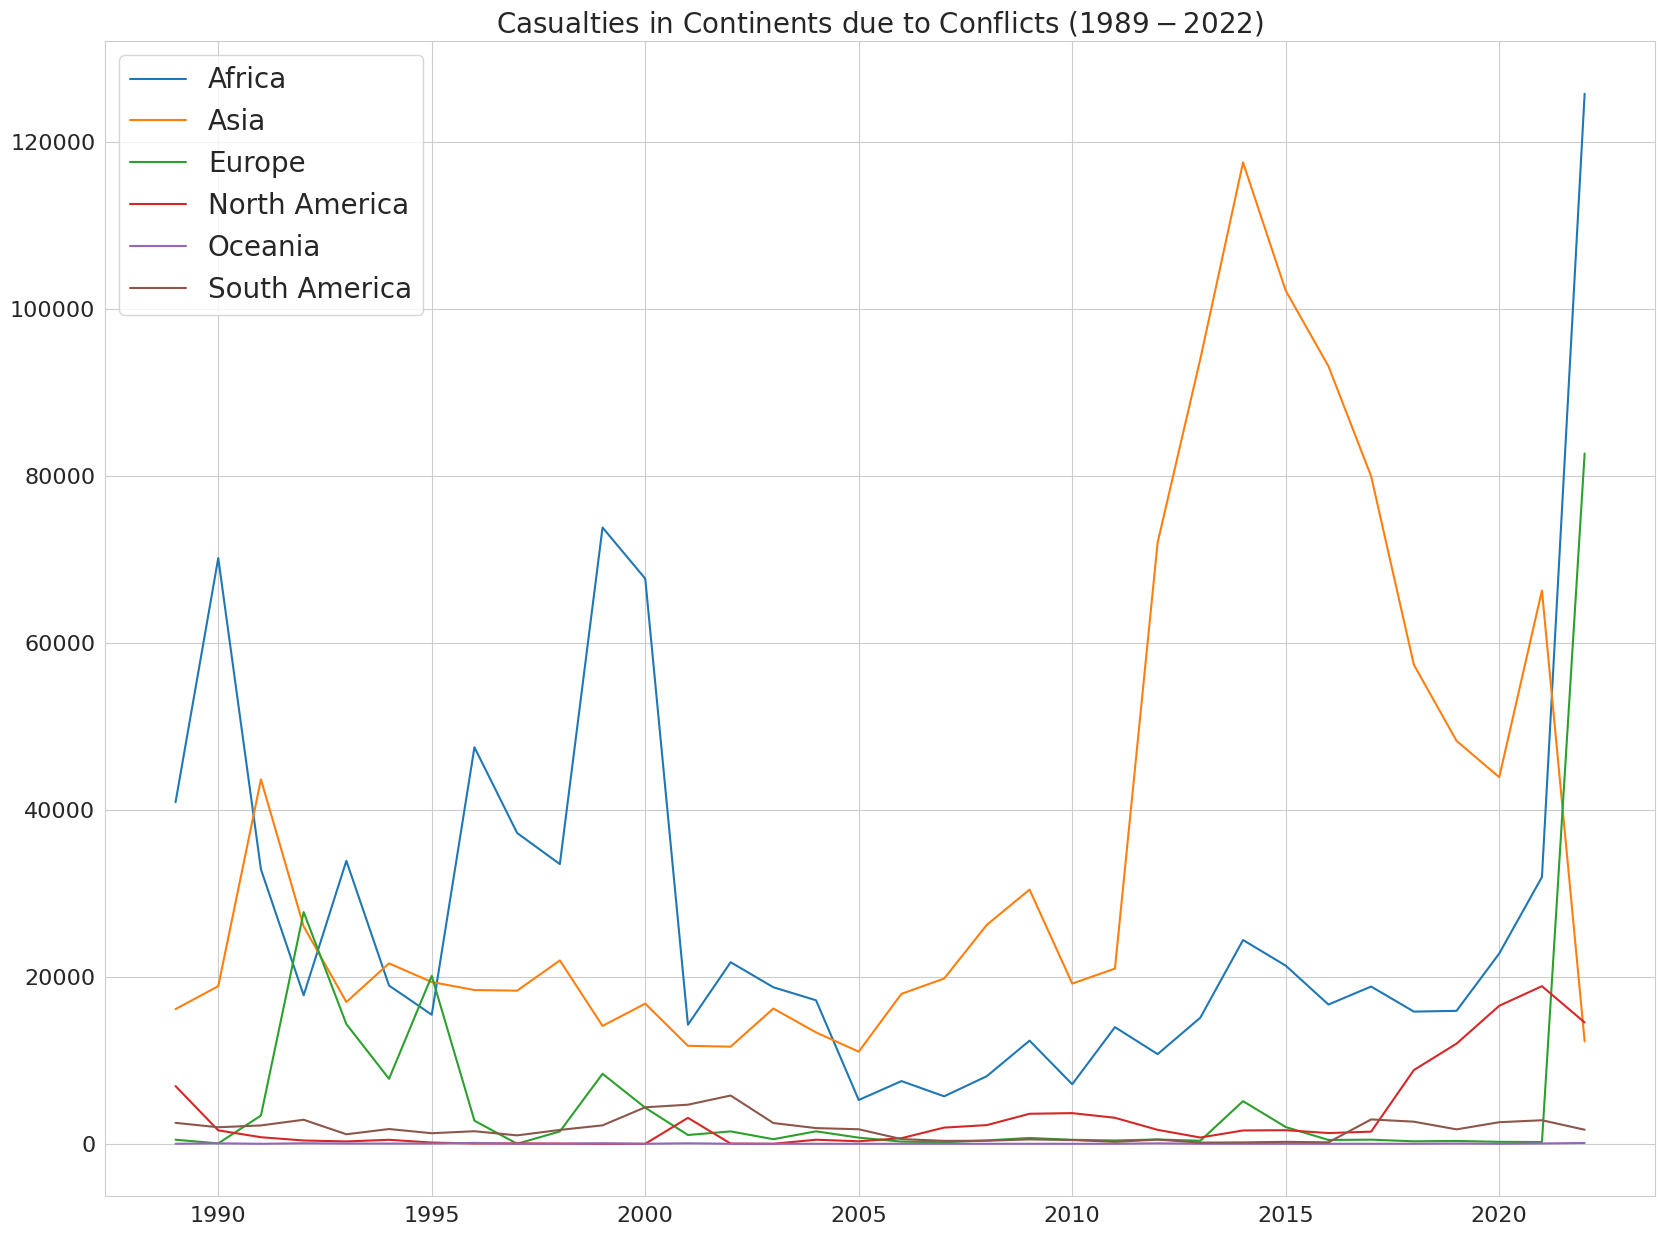

In [287]:
plot_distribution_of_casualties_by_continent()

In [288]:
def plot_countries_with_top_casualties_bar(max_countries=10):
    """
    Given `max_countries`, plot the first `max_countries` with the most casualties
    """
    overview_df = pd.DataFrame(
        {
            "Total Deaths": dataset.groupby("Country")["Deaths"]
            .sum()
            .sort_values(ascending=False),
            "Continent": dataset.groupby("Country")["Continent"].first(),
        }
    )
    
    # Rename D.R.C to fit into image size
    overview_df.rename(index={'Democratic Republic of Congo':'D.R.C'}, inplace=True)
    
    plt.figure(figsize=LARGE_FIGSIZE)
    plt.title(
        "Top 10 Countries with the highest casualties due to conflicts (all time)",
        fontsize=18,
    )
    plt.xlabel("Total Deaths", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    ax = sns.barplot(
        data=overview_df.sort_values(["Total Deaths"], ascending=False).iloc[:10, :],
        y="Country",
        x="Total Deaths",
        hue="Continent",
        orient="h",
    )
    ax.set(ylabel=None)
    plt.legend(fontsize=20)
    plt.savefig(f"figures/Top {max_countries} with the highest casualties.png")

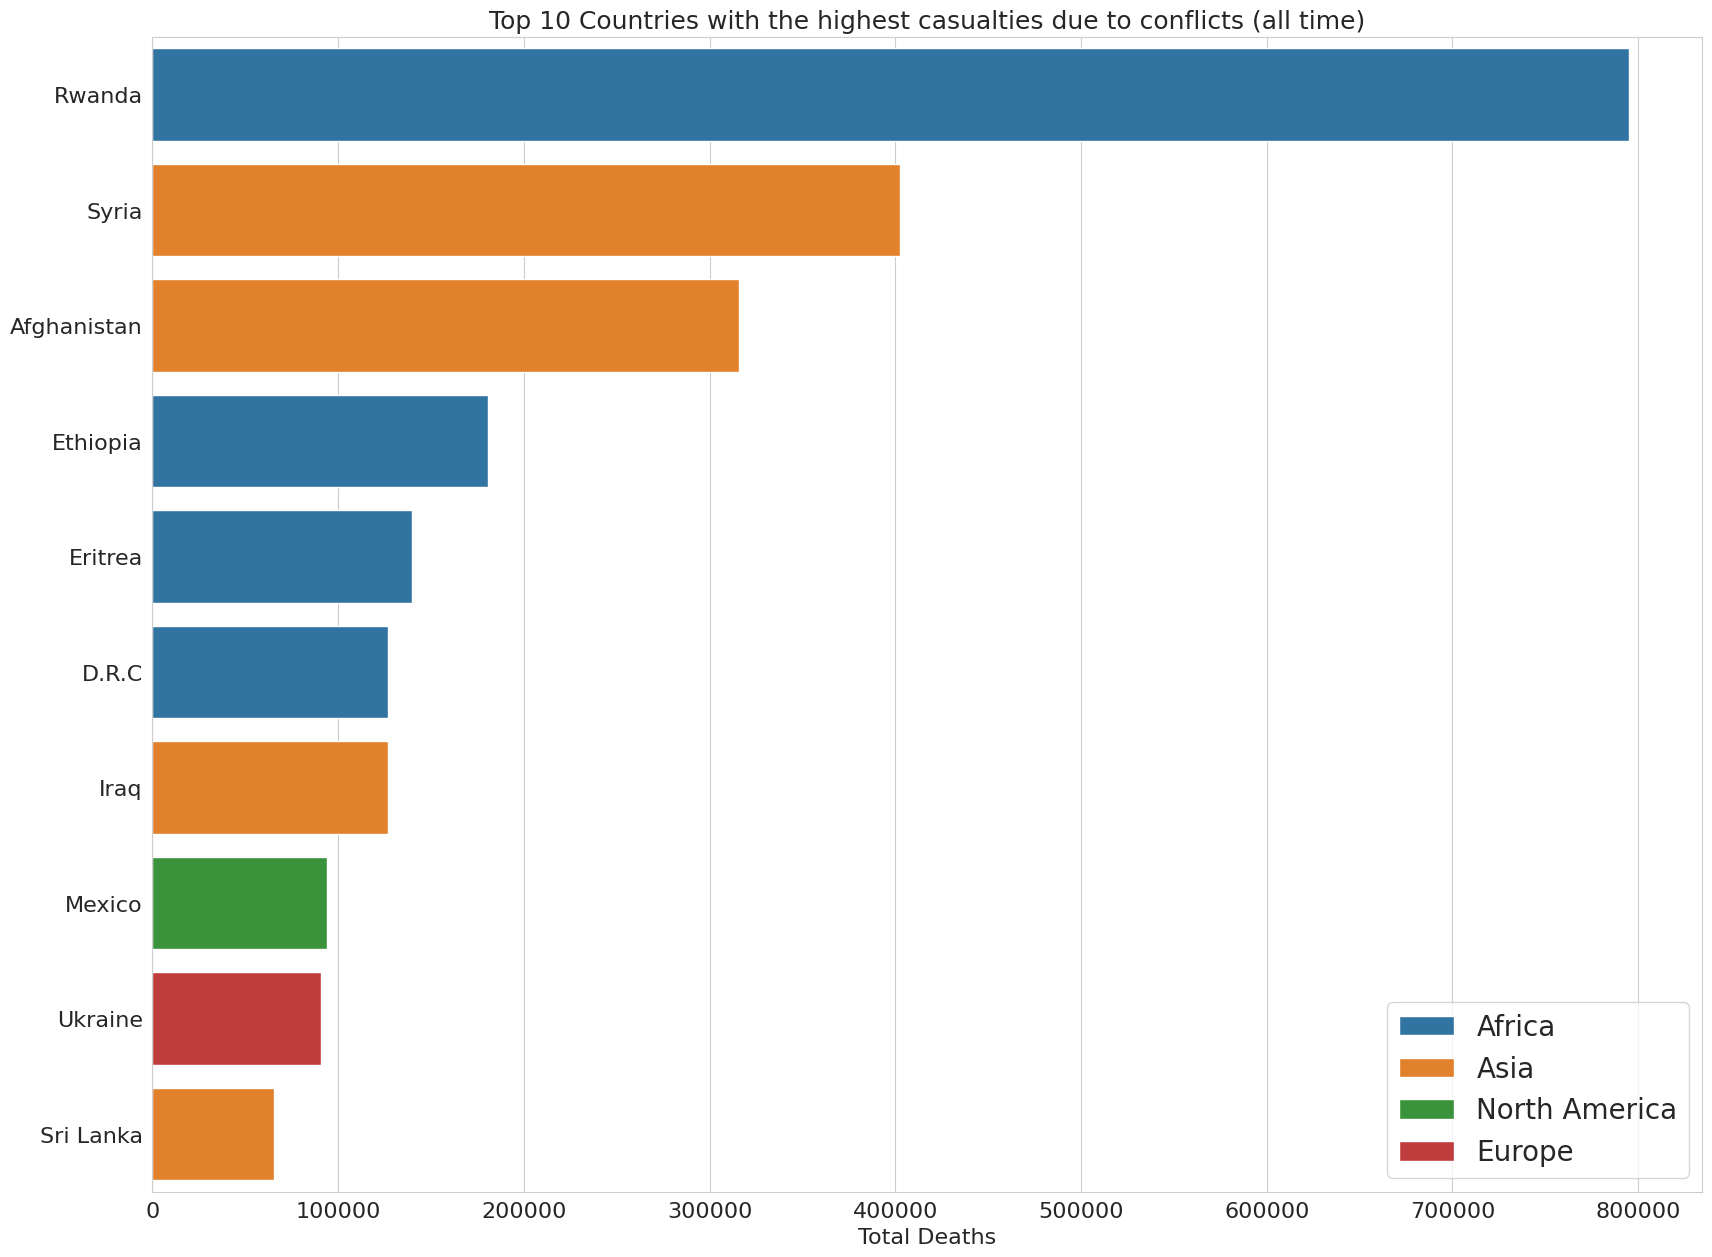

In [289]:
plot_countries_with_top_casualties_bar(max_countries=10)

4/10 countries are from Africa! Another 4 are from Asia, and only one from Europe and North America.

In [290]:
def plot_countries_without_casualties_infographic():
    """
    Determine the number of countries without a single recorded casualty.
    """
    d = dataset.groupby("Country")["Deaths"].sum()
    countries_without_casualties = d[d == 0].count()
    
    plt.figure(figsize=(7, 3.5))
    plt.text(
        0.2,
        0.5,
        countries_without_casualties,
        size=50,
        rotation=0,
        ha="center",
        va="center",
        bbox=dict(
            boxstyle="round",
            ec=(0.5, 1.0, 0.5),
            fc=(0.8, 1.0, 0.8),
        ),
    )
    
    plt.text(
        0.35,
        0.55,
        "countries",
        size=30,
        rotation=0,
        ha="left",
        va="center",
    )
    
    plt.text(
        0.35,
        0.40,
        "without a casualty",
        size=20,
        rotation=0,
        ha="left",
        va="center",
    )
    
    plt.axis("off")
    plt.savefig("figures/Count - countries without casualties.png")

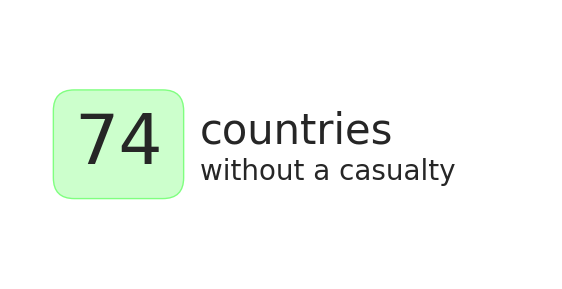

In [291]:
plot_countries_without_casualties_infographic()

In comparison, we have 74 different countries that haven't recorded a single casualty in a conflict within the past 30 years!


In [246]:
def label_pie_orig(total: int):
    """
    Helper function, to label pie chart with original values
    """
    # Original value = Percentage / 100 * Total value
    return lambda x: int(np.round(x / 100 * total, 0))

In [247]:
def plot_distribution_of_countries_with_no_casualties():
    """
    Plot a pie chart of the no. countries without casualties and their respective
    continents
    """
    overview_df = pd.DataFrame(
        {
            "Total Deaths": dataset.groupby("Country")["Deaths"]
            .sum()
            .sort_values(ascending=False),
            "Continent": dataset.groupby("Country")["Continent"].first(),
        }
    )
    
    # Rename D.R.C to fit into image size
    overview_df.rename(index={'Democratic Republic of Congo':'D.R.C'}, inplace=True)

    countries_no_deaths = pd.DataFrame(
        {
        'Countries Without Casualties': overview_df[overview_df["Total Deaths"] == 0].groupby("Continent").count()['Total Deaths'],
        'Countries in the Continent (incl. historical countries)': overview_df.groupby("Continent").count()['Total Deaths'],
        }
    )

    fix, ax = plt.subplots(figsize=SMALL_FIGSIZE)
    t = table(ax, data=countries_no_deaths, loc='center', cellLoc='center')
    t.set_fontsize(14)
    t.scale(1,5)
    
    plt.axis('off')
    plt.savefig('figures/Distribution of Countries With No Casualties.png')

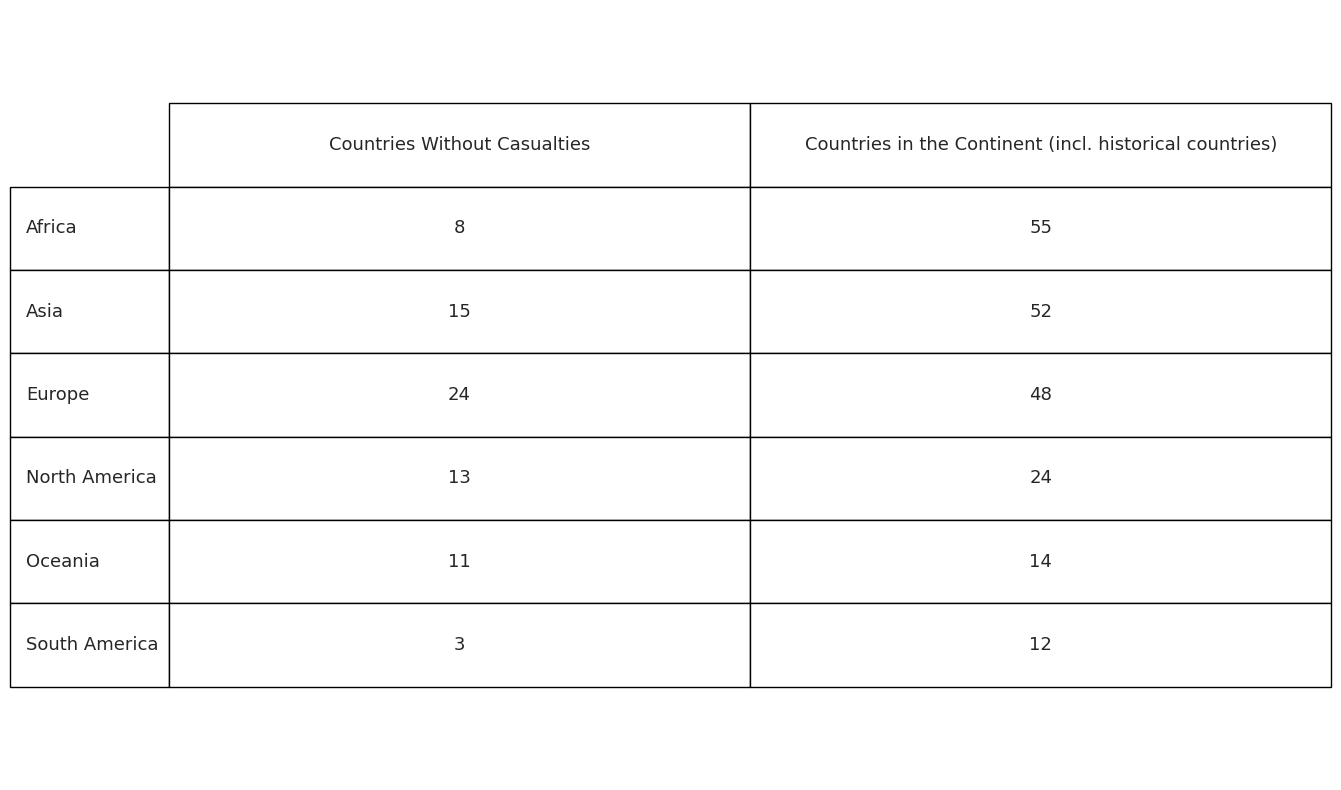

In [248]:
plot_distribution_of_countries_with_no_casualties()

In [249]:
# def plot_distribution_of_countries():
#     """
#     Plot a pie chart of the no. countries and their respective continents
#     """
#     continents_countries = dataset.groupby("Continent")["Country"].unique().to_dict()
#     count_continents_countries = {
#         continent: len(countries) for continent, countries in continents_countries.items()
#     }
    
#     plt.title(
#         "Countries in the world (including historical countries)",
#         fontsize=16,
#     )
#     plt.xlabel(None, fontsize=14)
#     ax = plt.pie(
#         count_continents_countries.values(),
#         labels=count_continents_countries.keys(),
#         autopct=label_pie_orig(sum(count_continents_countries.values())),
#         textprops={"fontsize": 14},
#     )
#     plt.savefig(
#         "figures/Countries in the world (including historical countries).png"
#     )

In [250]:
# plot_distribution_of_countries()

## Bar Chart - Casualties

In [292]:
def create_group_bins(df, col, bins):
    """
    Get index for custom group/bin size in dataset.
    Used to group data by every 5 years using cut
    """
    groups = pd.cut(df[col], bins=bins, labels=False)
    return df.groupby(groups)


def plot_casualties_bar_chart(continent, bin_size=10):
    continent_colors = {
        "Africa": [0.30, 0.85, 0.30],
        "Europe": [0.50, 0.50, 0.90],
        "North America": [0.20, 0.20, 0.90],
        "South America": [0.60, 0.30, 0.90],
        "Oceania": [0.70, 0.40, 0.10],
        "Asia": [0.90, 0.40, 0.30],
    }

    plt.figure(figsize=SMALL_FIGSIZE)
    plt.title(f"Casualties in Continents due to Conflicts in {continent} (1989 - 2022)", fontsize=18)

    plt.xlabel(None, fontsize=16)

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    continent_df = dataset[dataset["Continent"] == continent]

    # group = dataset.iloc[continent_[group_name], :]
    grouped_data = create_group_bins(continent_df.copy(), "Year", range(1985, 2025, 5))
    year_trend = continent_df.groupby("Year")["Deaths"].sum().to_dict()

    # year_trend = grouped_data['Deaths'].sum().to_dict()
    bins = {}
    for bin_index, bin in enumerate(
        range(int(min(year_trend.keys())), int(max(year_trend.keys())), bin_size)
    ):
        # print(bin, min(year_trend.keys()), year_trend)
        limit = bin + bin_size
        bins[f"{bin}-{limit - 1}"] = sum(
            [
                value
                for year, value in year_trend.items()
                if year >= bin and year < limit
            ]
        )

    sns.barplot(
        x=bins.keys(),
        y=bins.values(),
        label=continent,
        color=continent_colors[continent],
    )
    plt.legend(fontsize=20)
    plt.savefig(f'figures/Bar Plot - Casualties in Continent - {continent}.png')

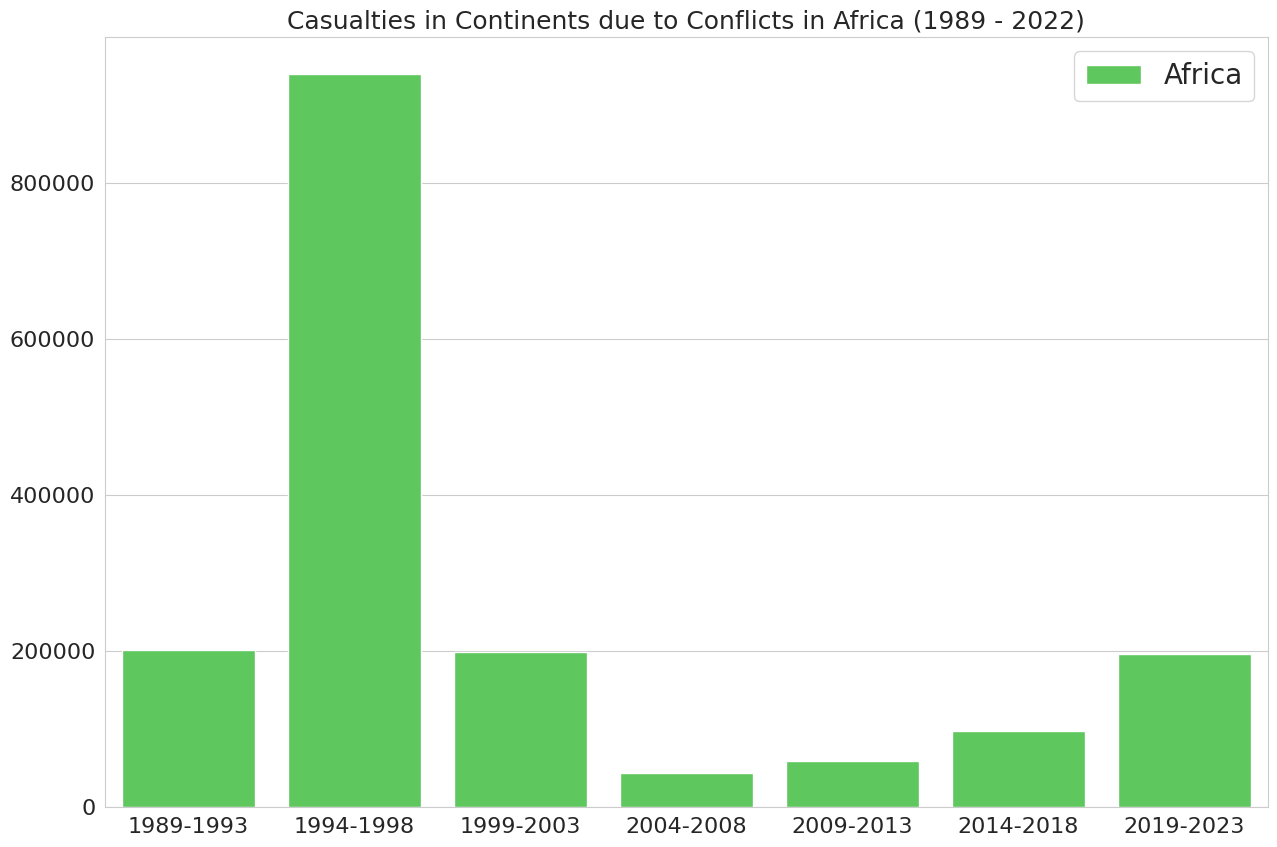

In [293]:
plot_casualties_bar_chart(continent="Africa", bin_size=5)

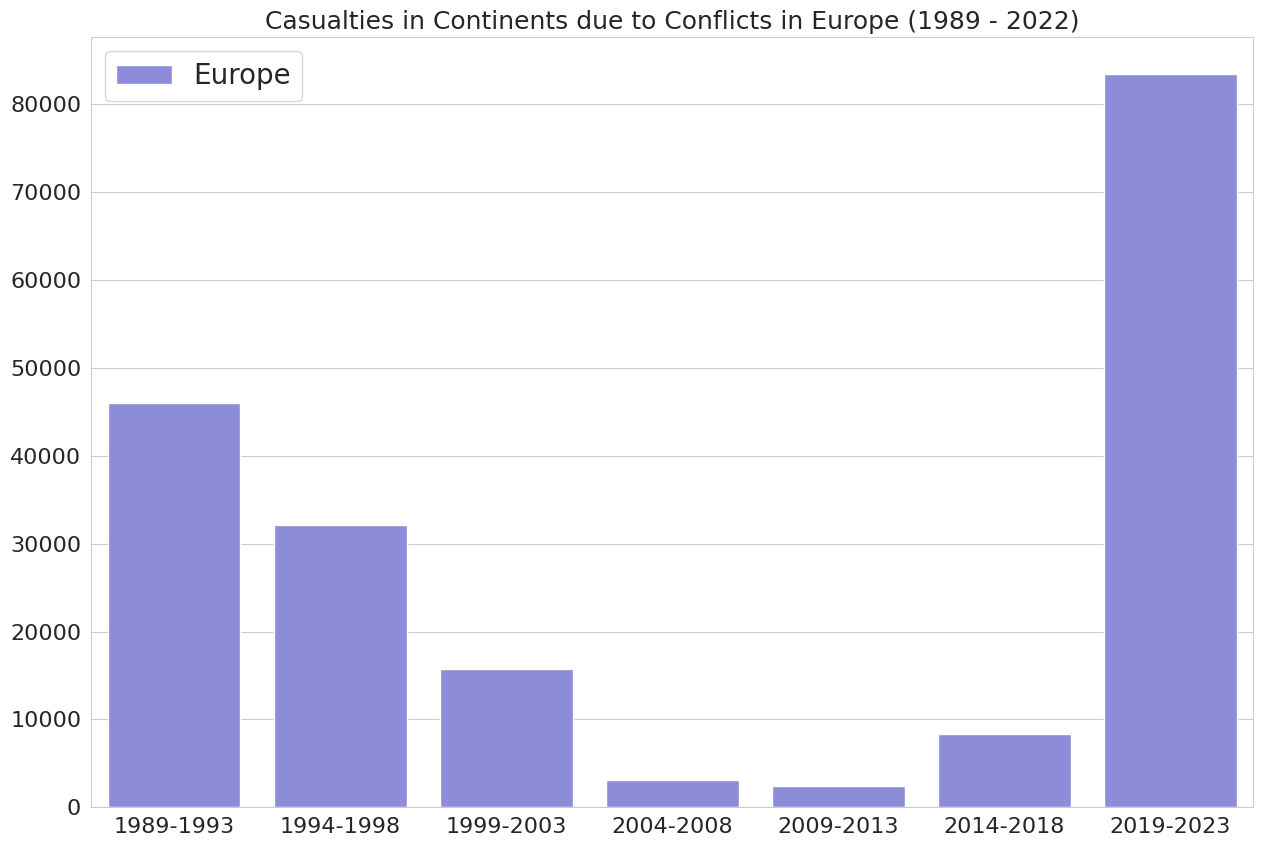

In [294]:
plot_casualties_bar_chart(continent="Europe", bin_size=5)

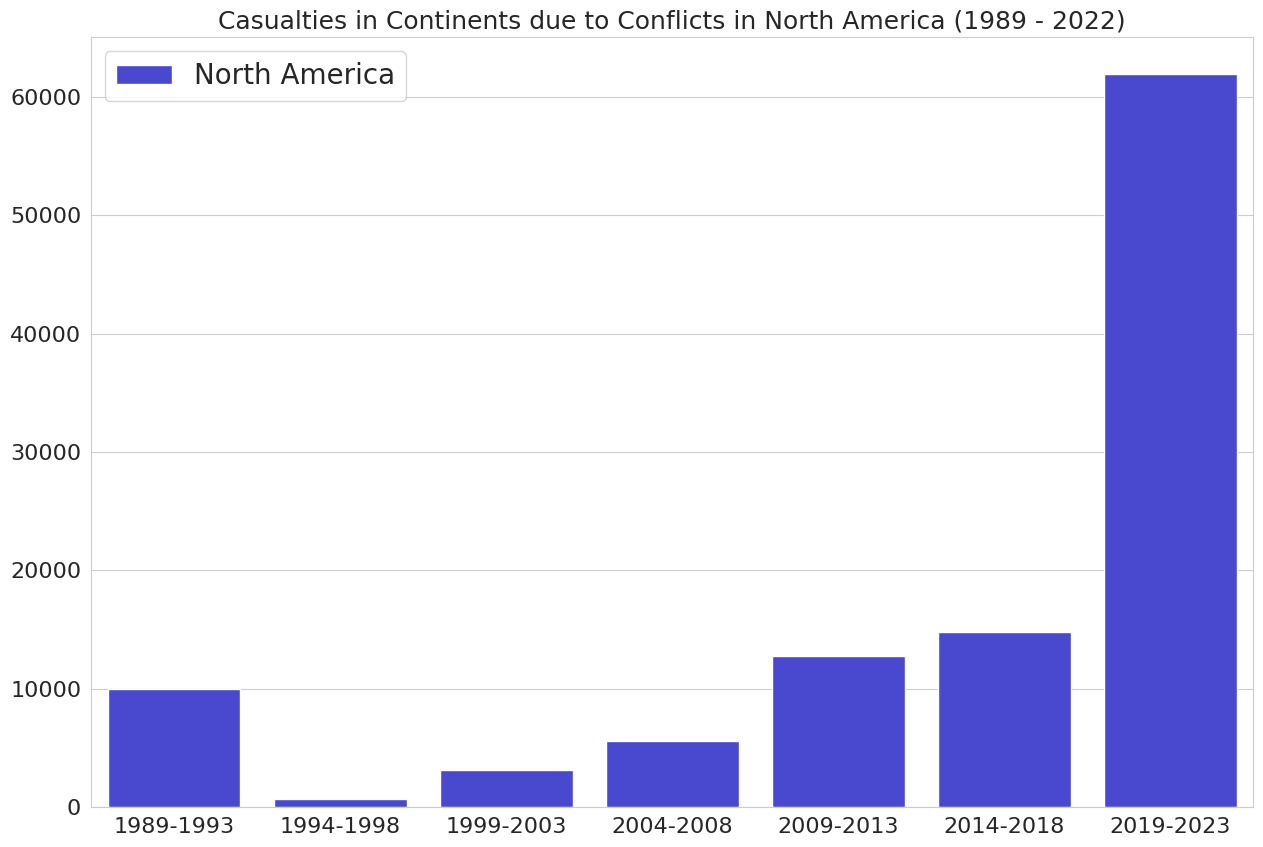

In [295]:
plot_casualties_bar_chart(continent="North America", bin_size=5)

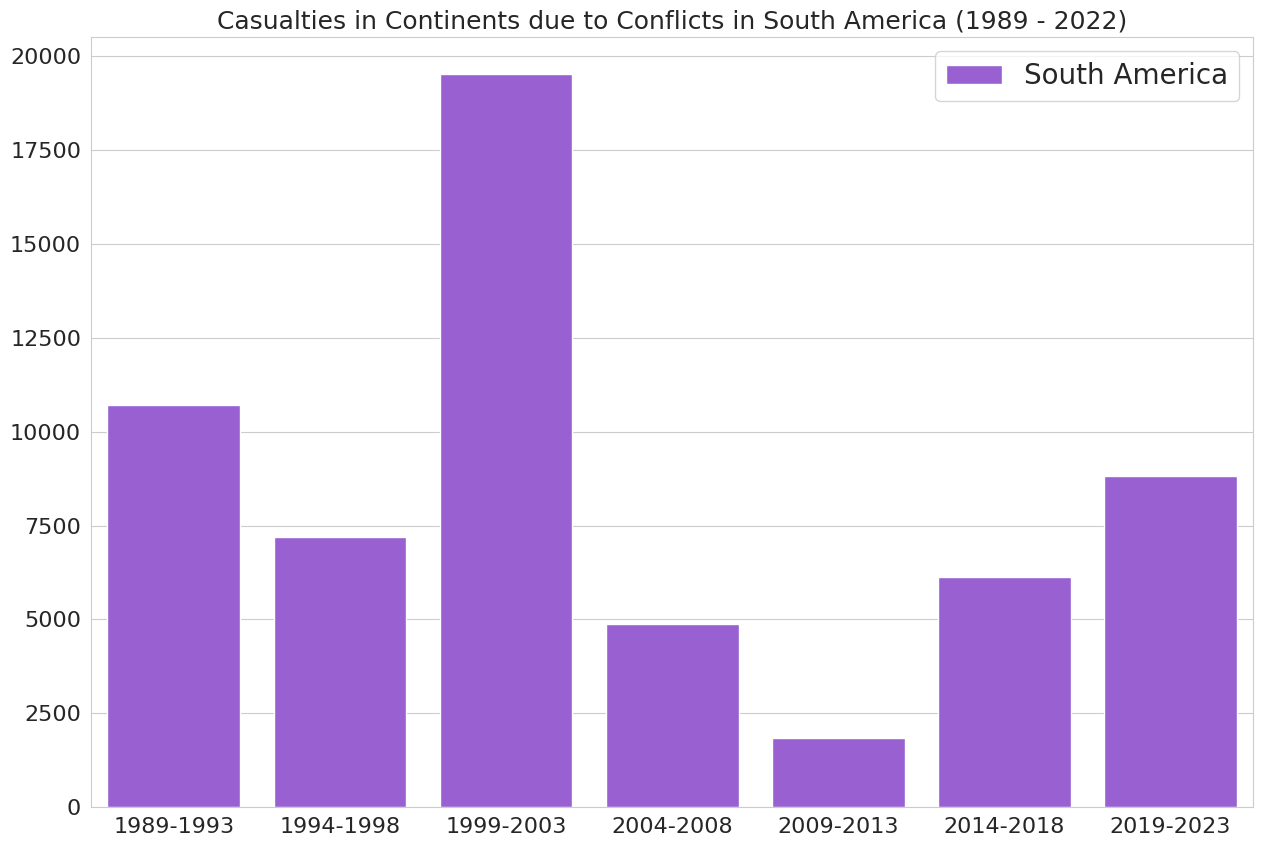

In [296]:
plot_casualties_bar_chart(continent="South America", bin_size=5)

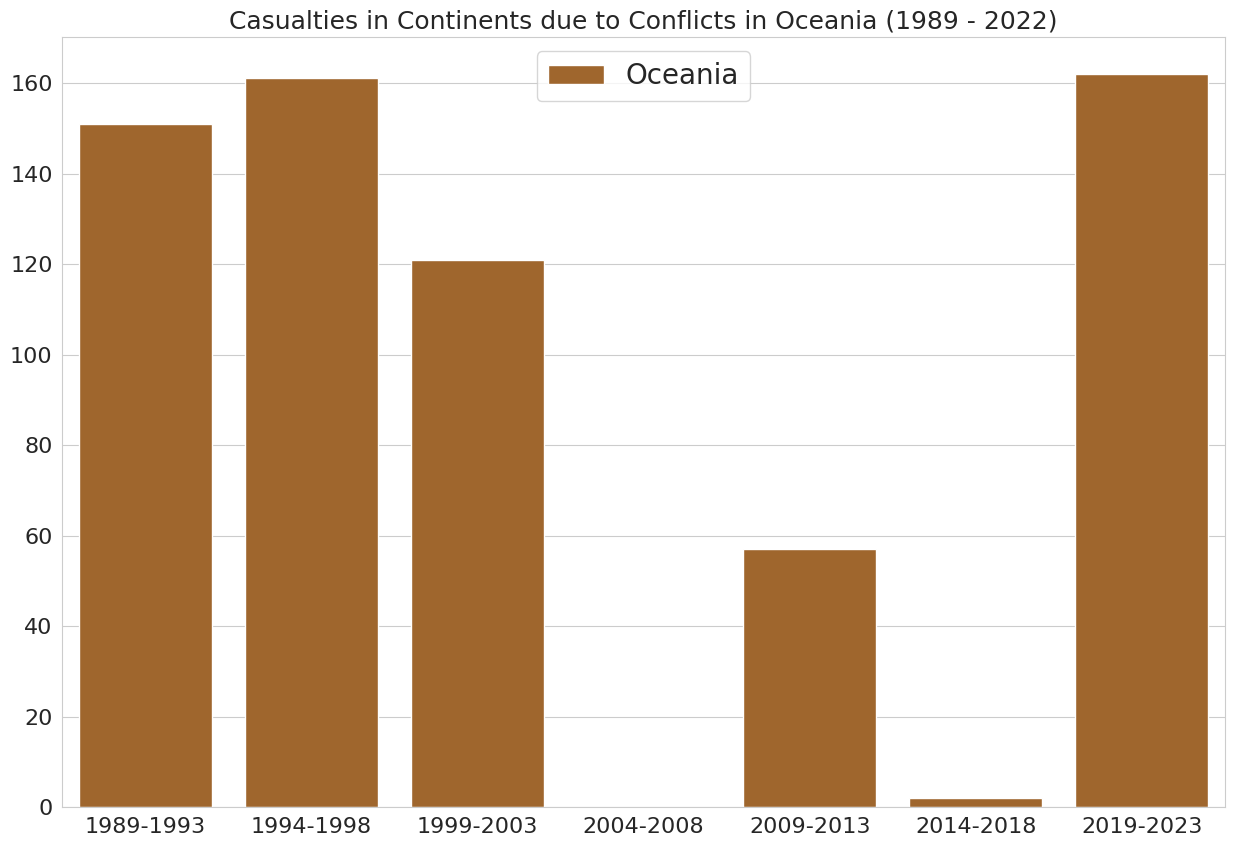

In [297]:
plot_casualties_bar_chart(continent="Oceania", bin_size=5)

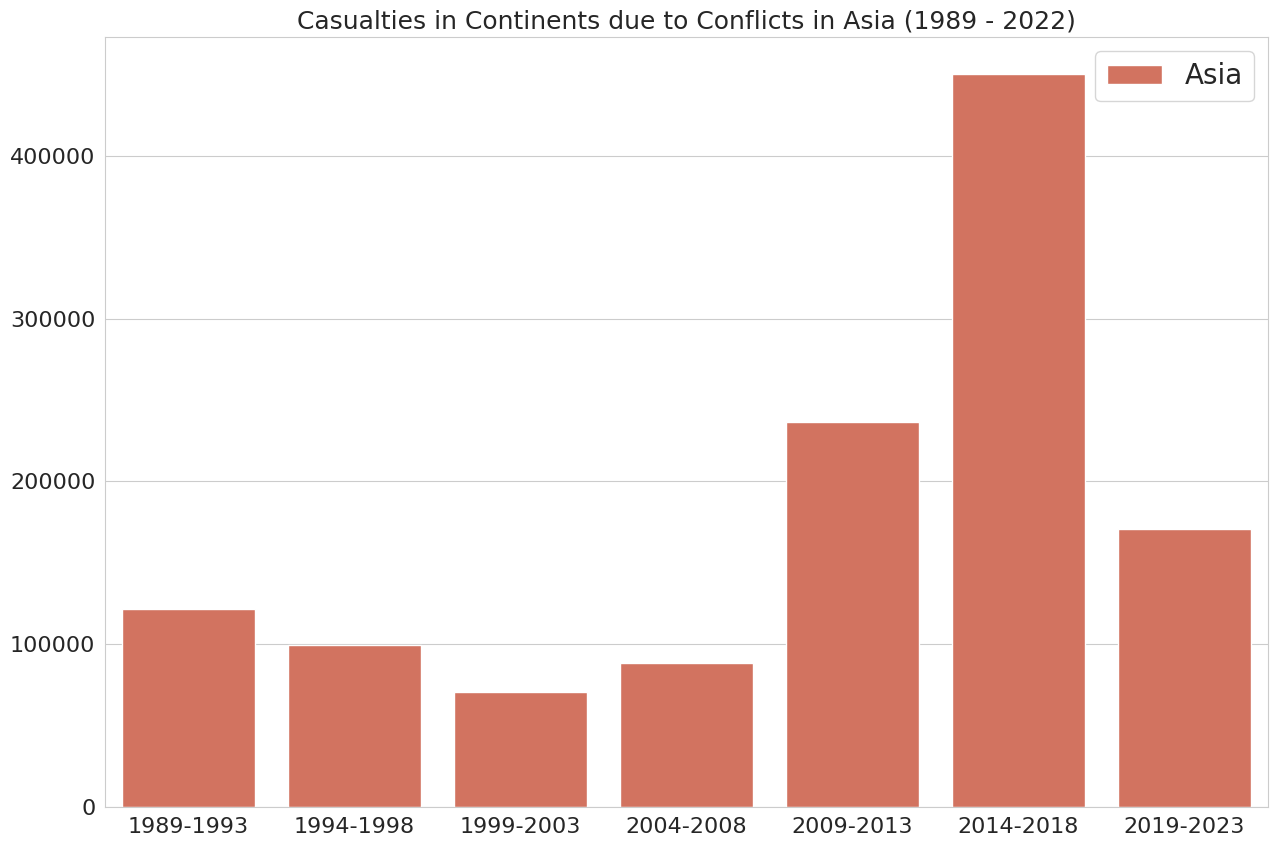

In [298]:
plot_casualties_bar_chart(continent="Asia", bin_size=5)

## GeoPandas Map Visualizations

In [258]:
def plot_global_casualties(min_year, max_year, continent=None):
    """
    Plot the global casualty levels for a period of years (inclusive)
    """
    casualties = dataset[(dataset["Year"] >= min_year) & (dataset["Year"] <= max_year)]
    country_gp = casualties.groupby("Country")
    df = pd.DataFrame(
        {
            "Total Deaths": country_gp["Deaths"].sum(),
            "Country Abbr": country_gp["Country Abbreviation"].first(),
        }
    )

    world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

    if continent:
        world = world[world["continent"] == continent]

    merge = world.merge(df, left_on="iso_a3", right_on="Country Abbr").sort_values(
        by="Total Deaths", ascending=False
    )
    merge.plot(
        column="Total Deaths",
        scheme="natural_breaks",
        k=12,
        figsize=LARGE_FIGSIZE,
        legend=False,
        cmap="OrRd",
    )
    plt.xticks([]), plt.yticks([])
    if continent:
        plt.title(
            f"Casualties due to Conflicts in {continent} ({min_year} - {max_year})",
            fontsize=28,
        )
    else:
        plt.title(f"Casualties due to Conflicts ({min_year} - {max_year})", fontsize=28)

    plt.savefig(f'figures/Geopandas - Casualties in Continent {continent} ({min_year} - {max_year}).png')

/tmp/ipykernel_547597/309742030.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


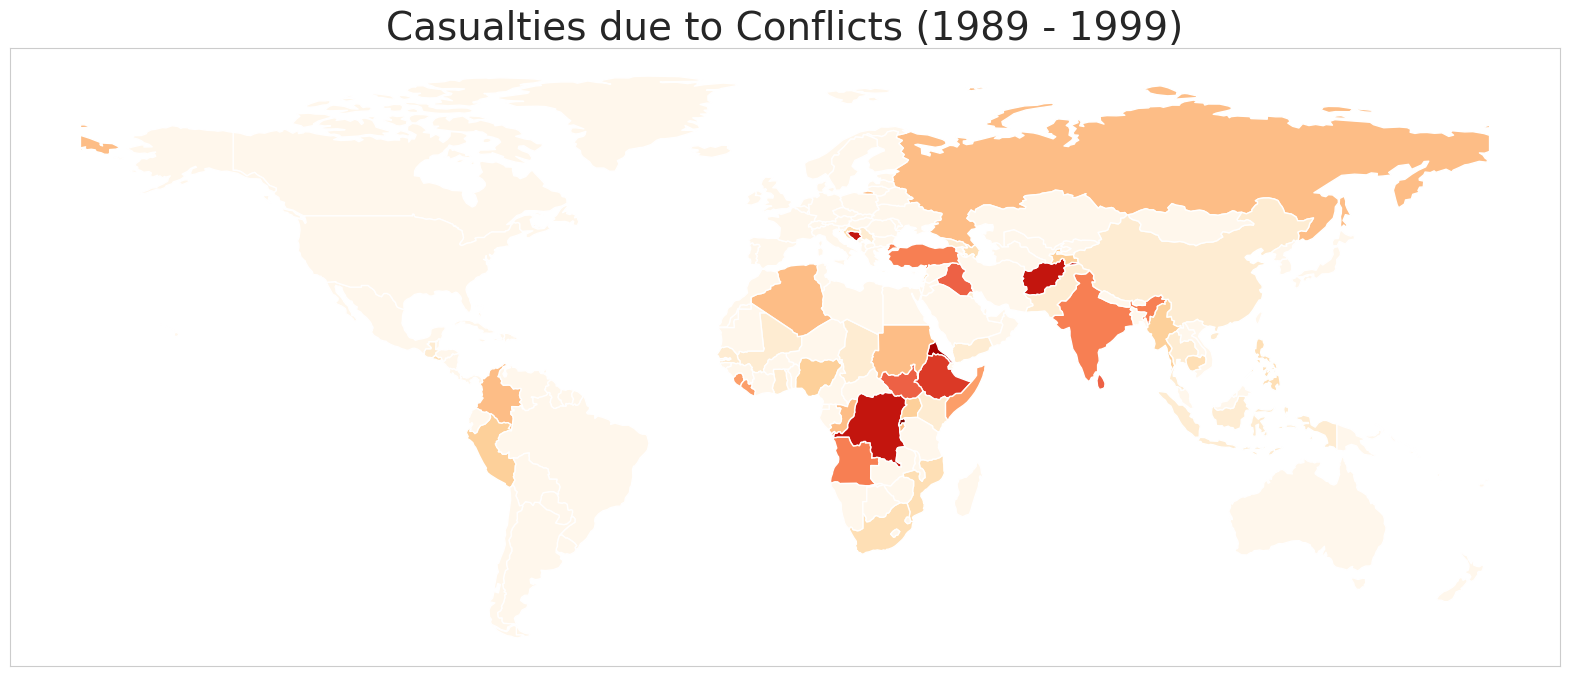

In [259]:
plot_global_casualties(1989, 1999)

/tmp/ipykernel_547597/309742030.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


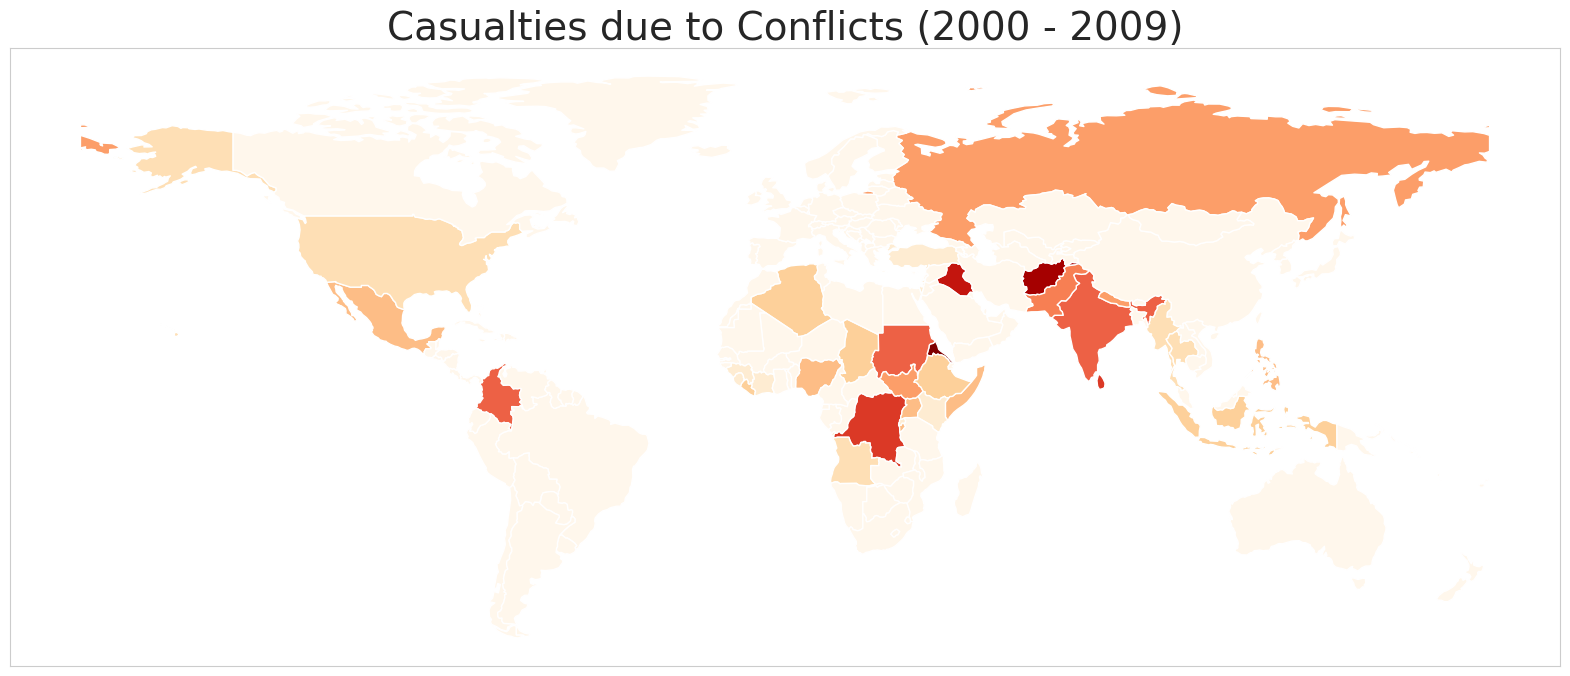

In [260]:
plot_global_casualties(2000, 2009)

/tmp/ipykernel_547597/309742030.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


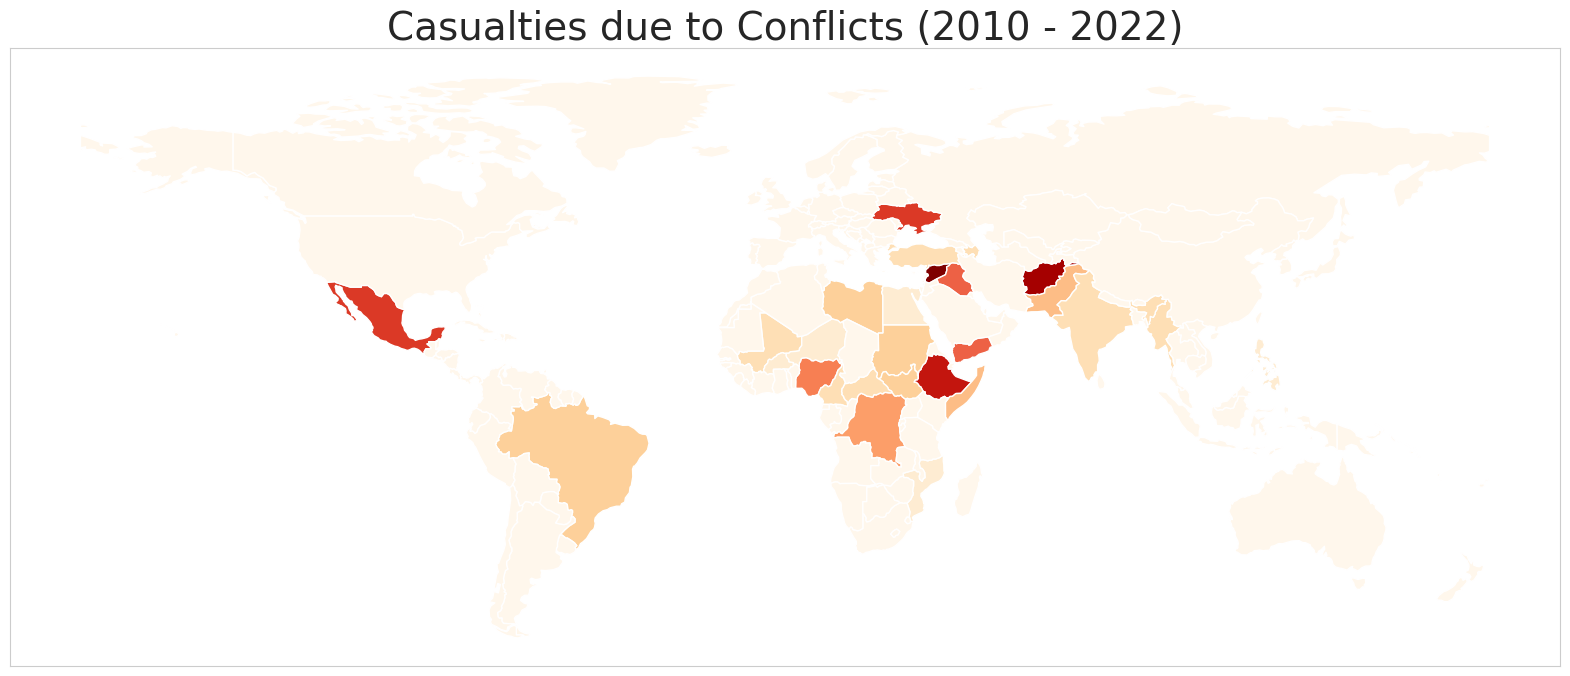

In [261]:
plot_global_casualties(2010, 2022)

/tmp/ipykernel_547597/309742030.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


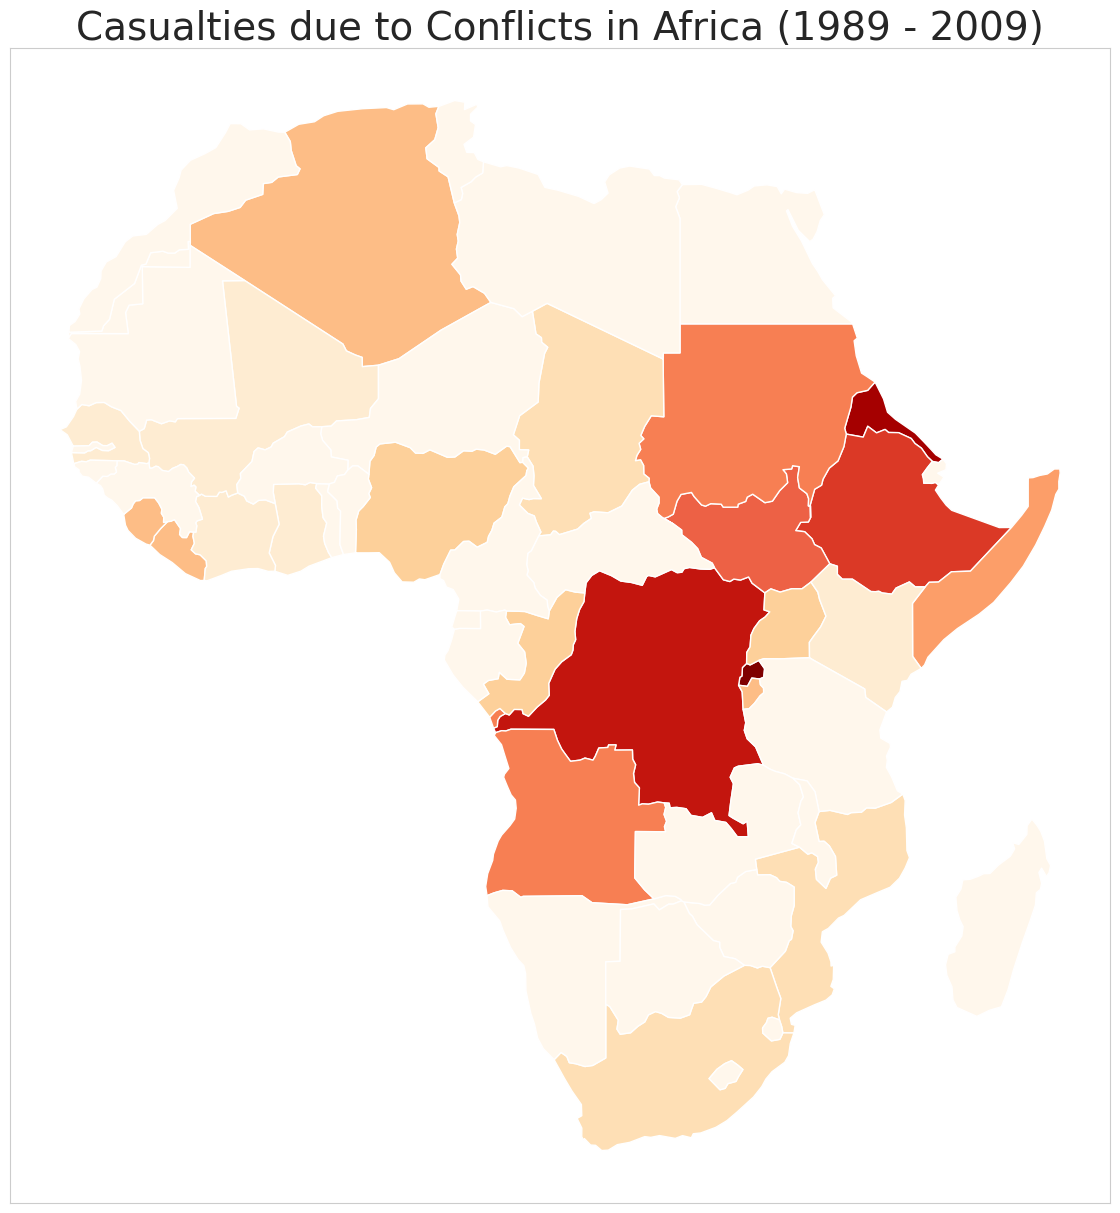

In [262]:
plot_global_casualties(1989, 2009, "Africa")

/tmp/ipykernel_547597/309742030.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


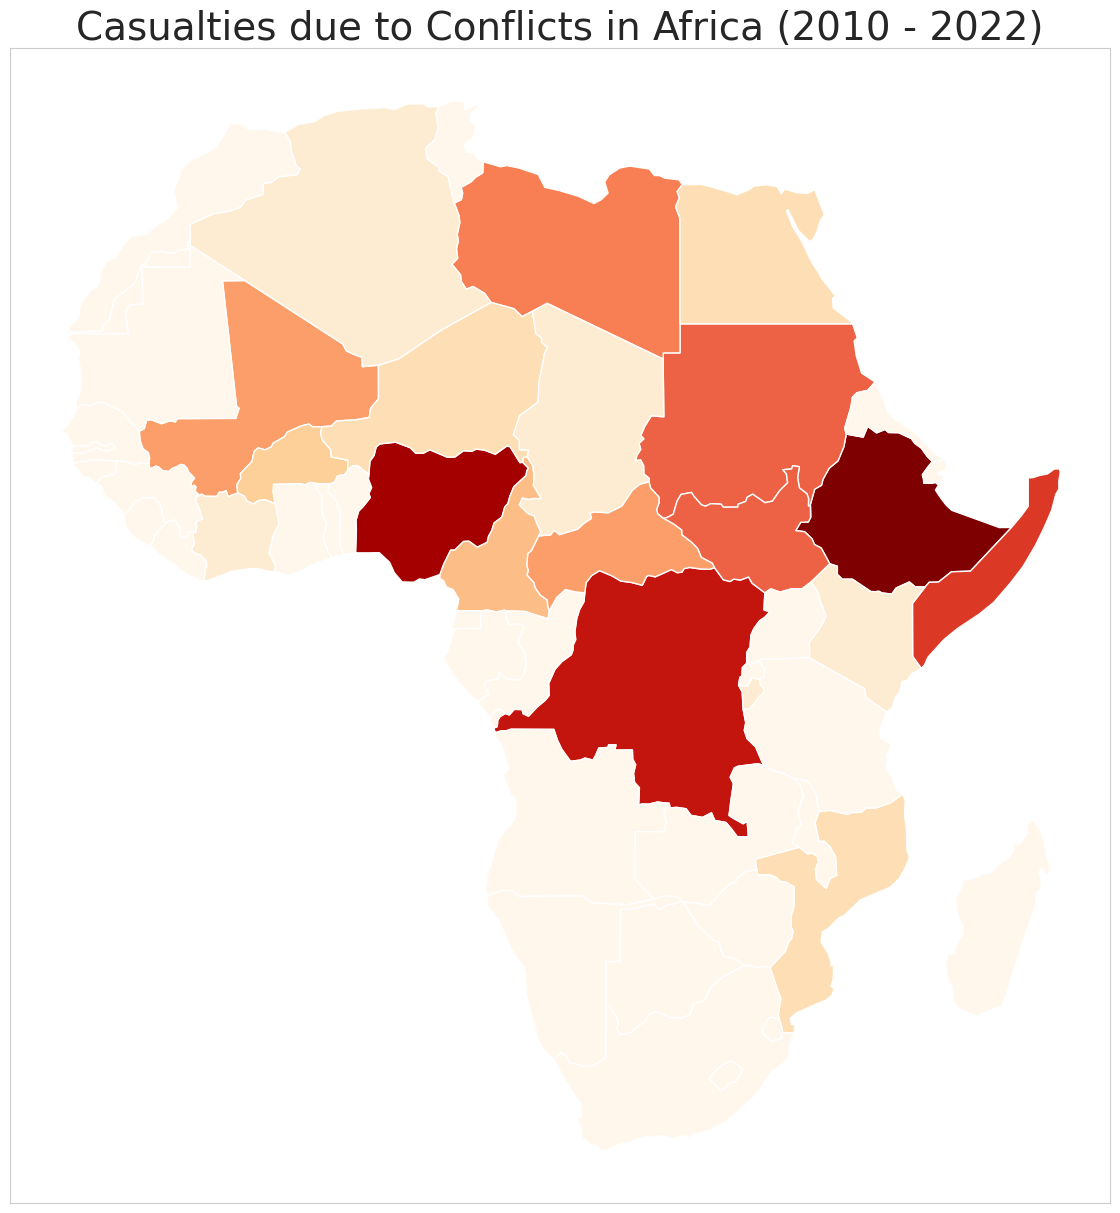

In [263]:
plot_global_casualties(2010, 2022, "Africa")

/tmp/ipykernel_547597/309742030.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


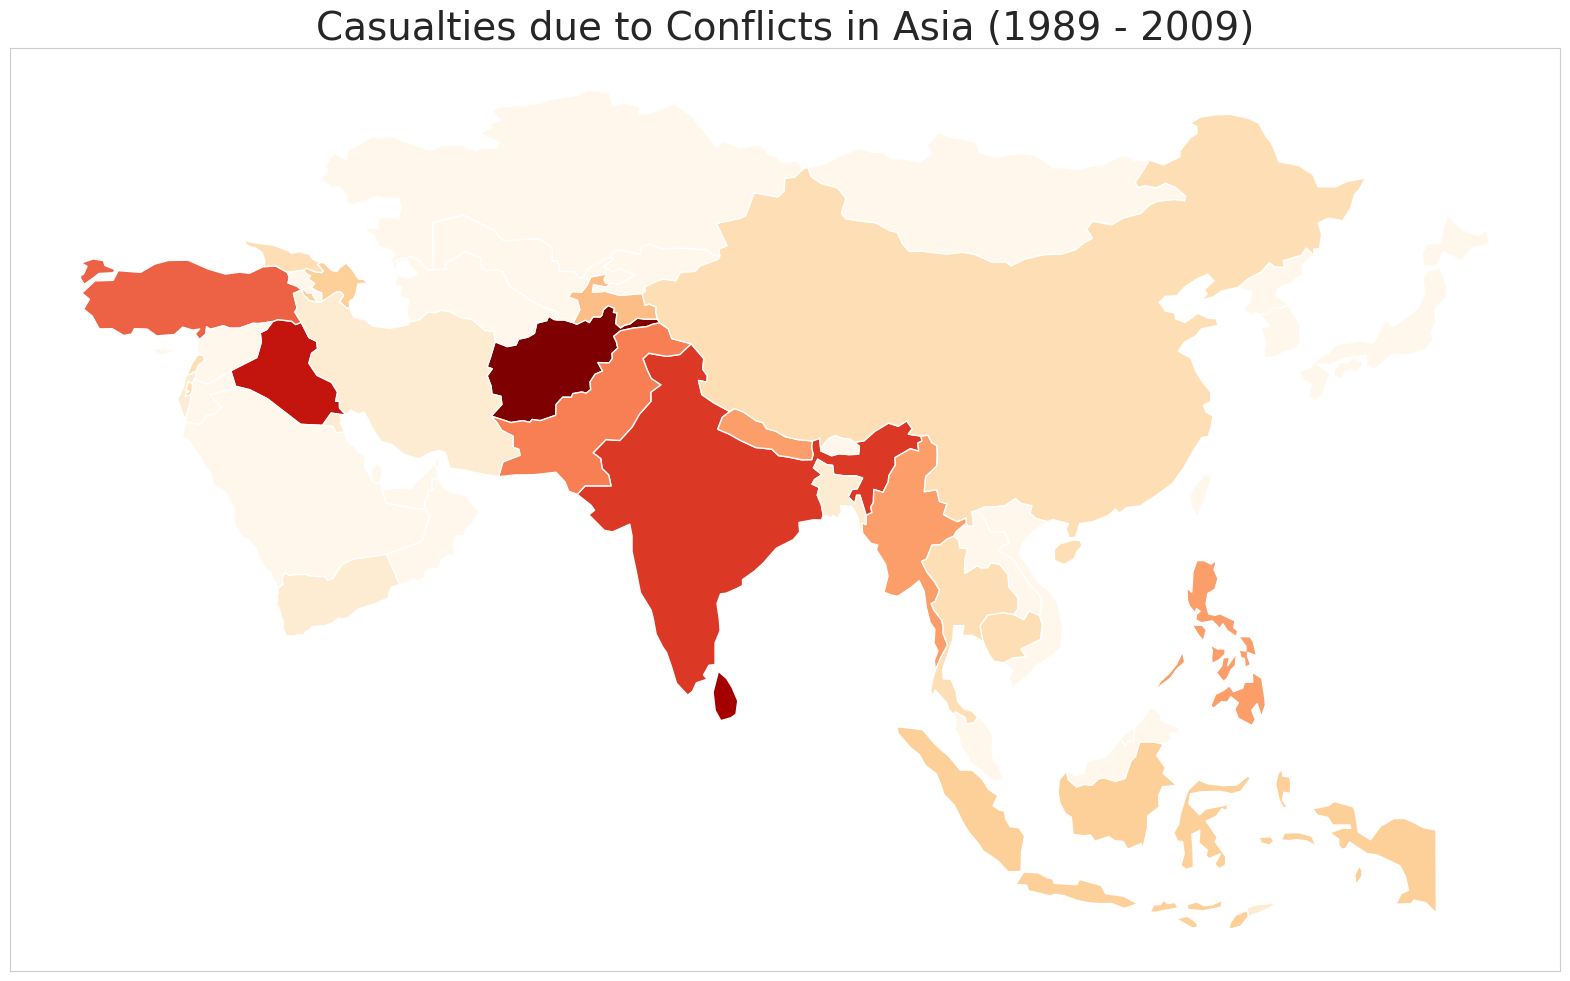

In [264]:
plot_global_casualties(1989, 2009, "Asia")

/tmp/ipykernel_547597/309742030.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


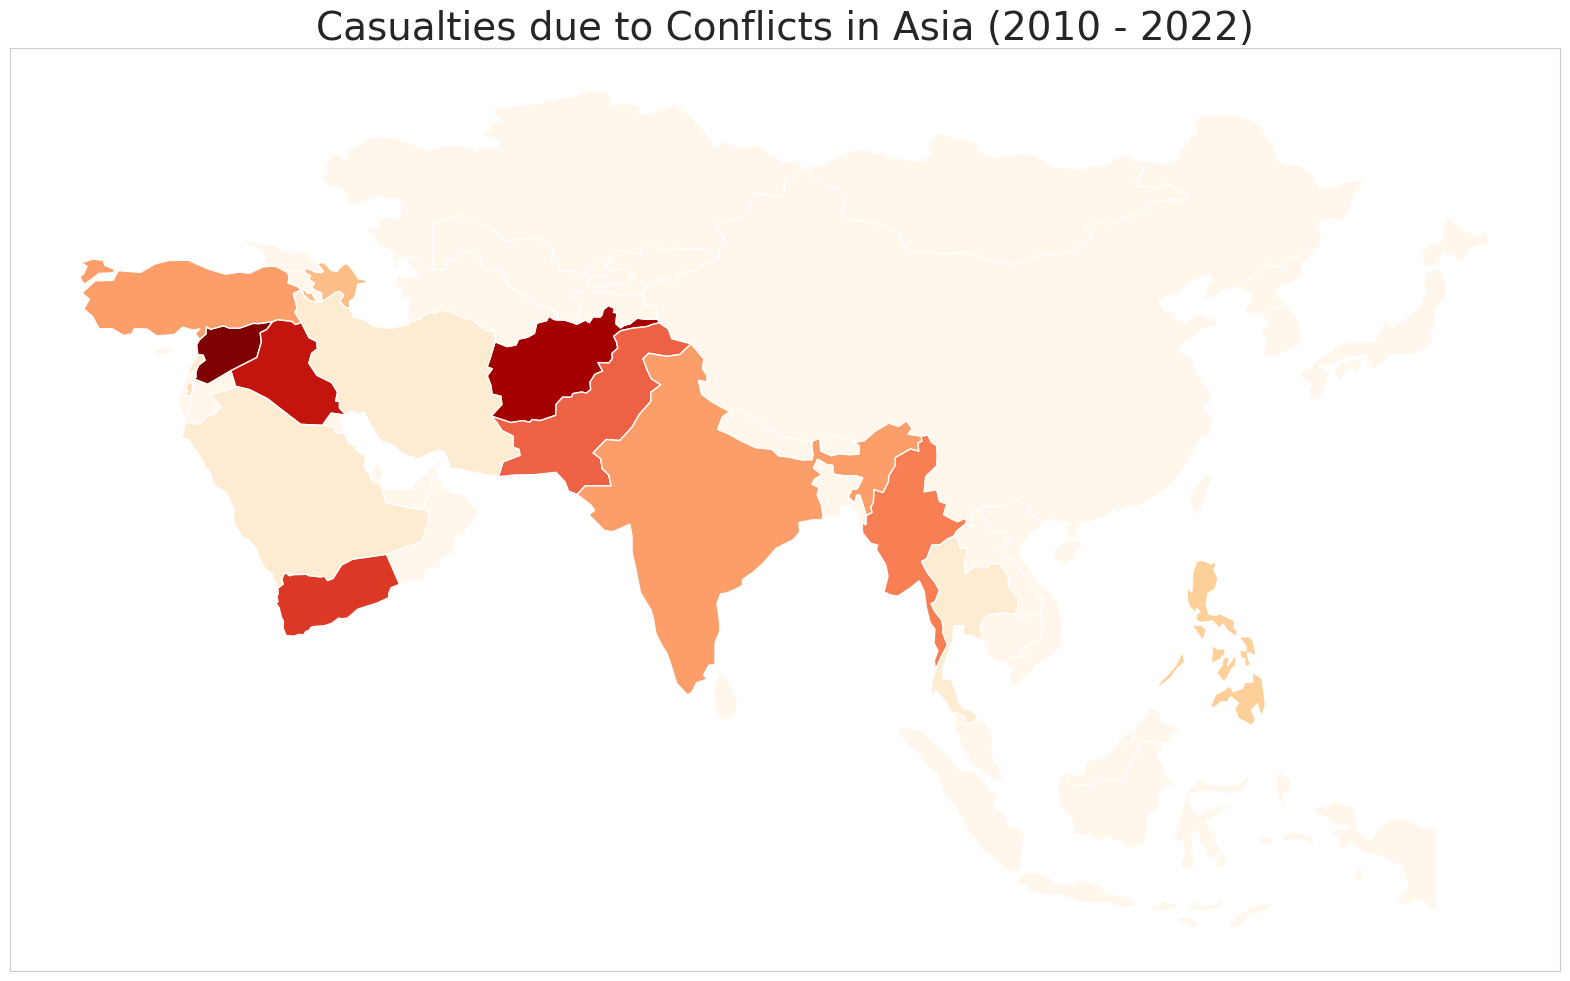

In [265]:
plot_global_casualties(2010, 2022, "Asia")

/tmp/ipykernel_547597/309742030.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


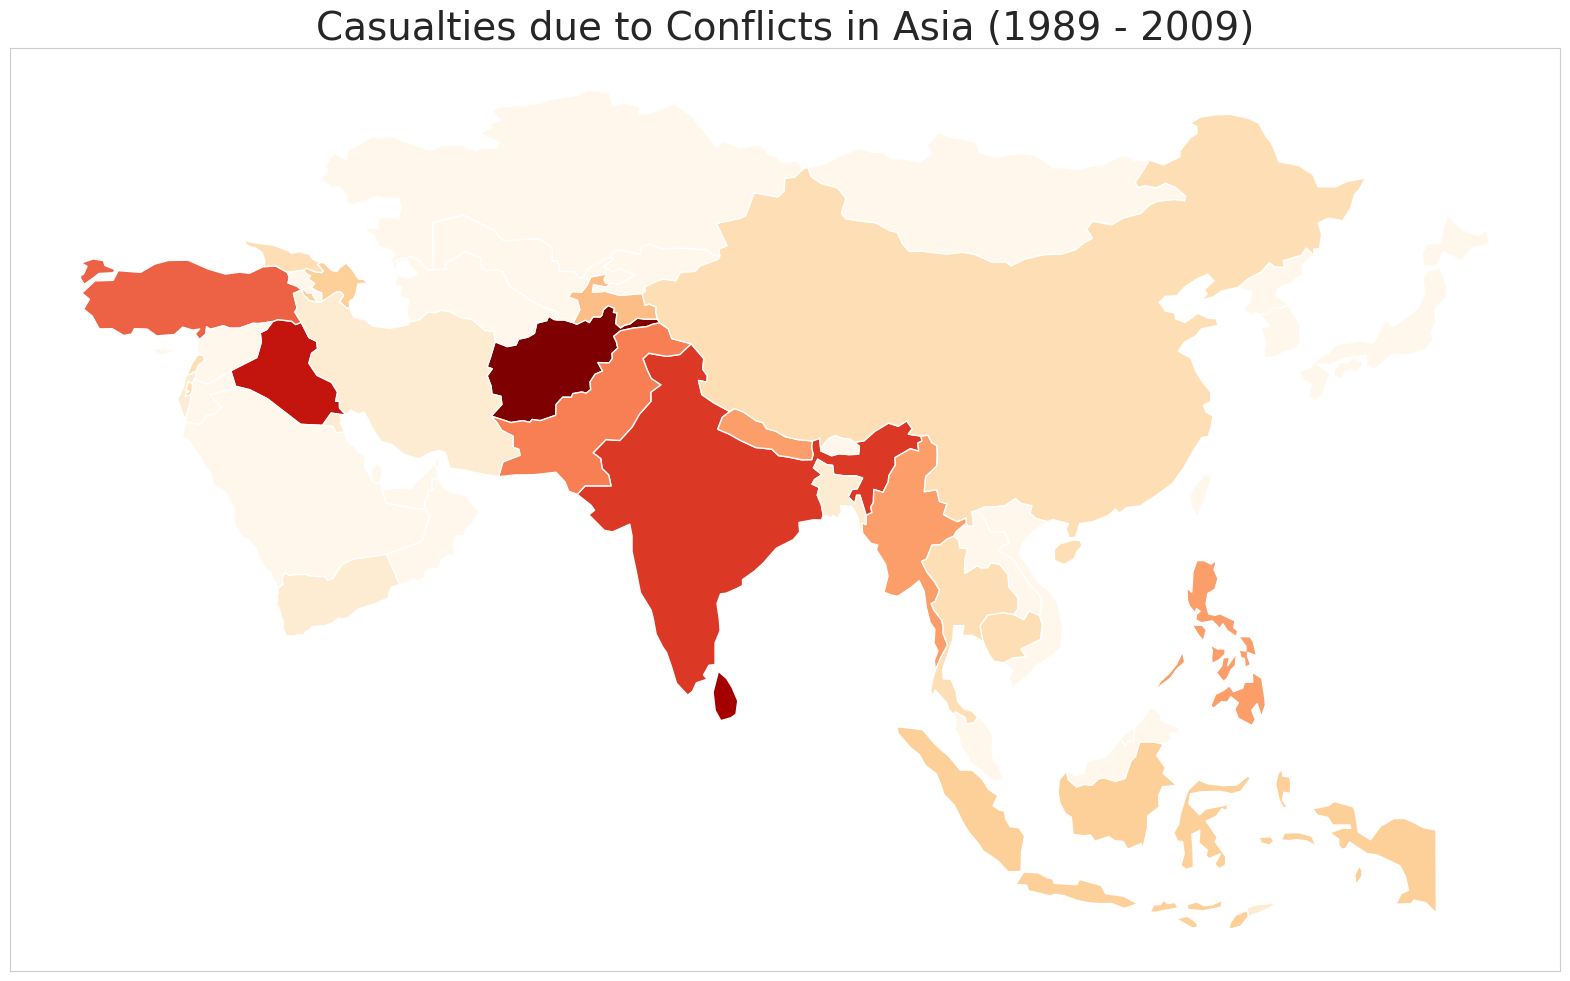

In [266]:
plot_global_casualties(1989, 2009, "Asia")

/tmp/ipykernel_547597/309742030.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


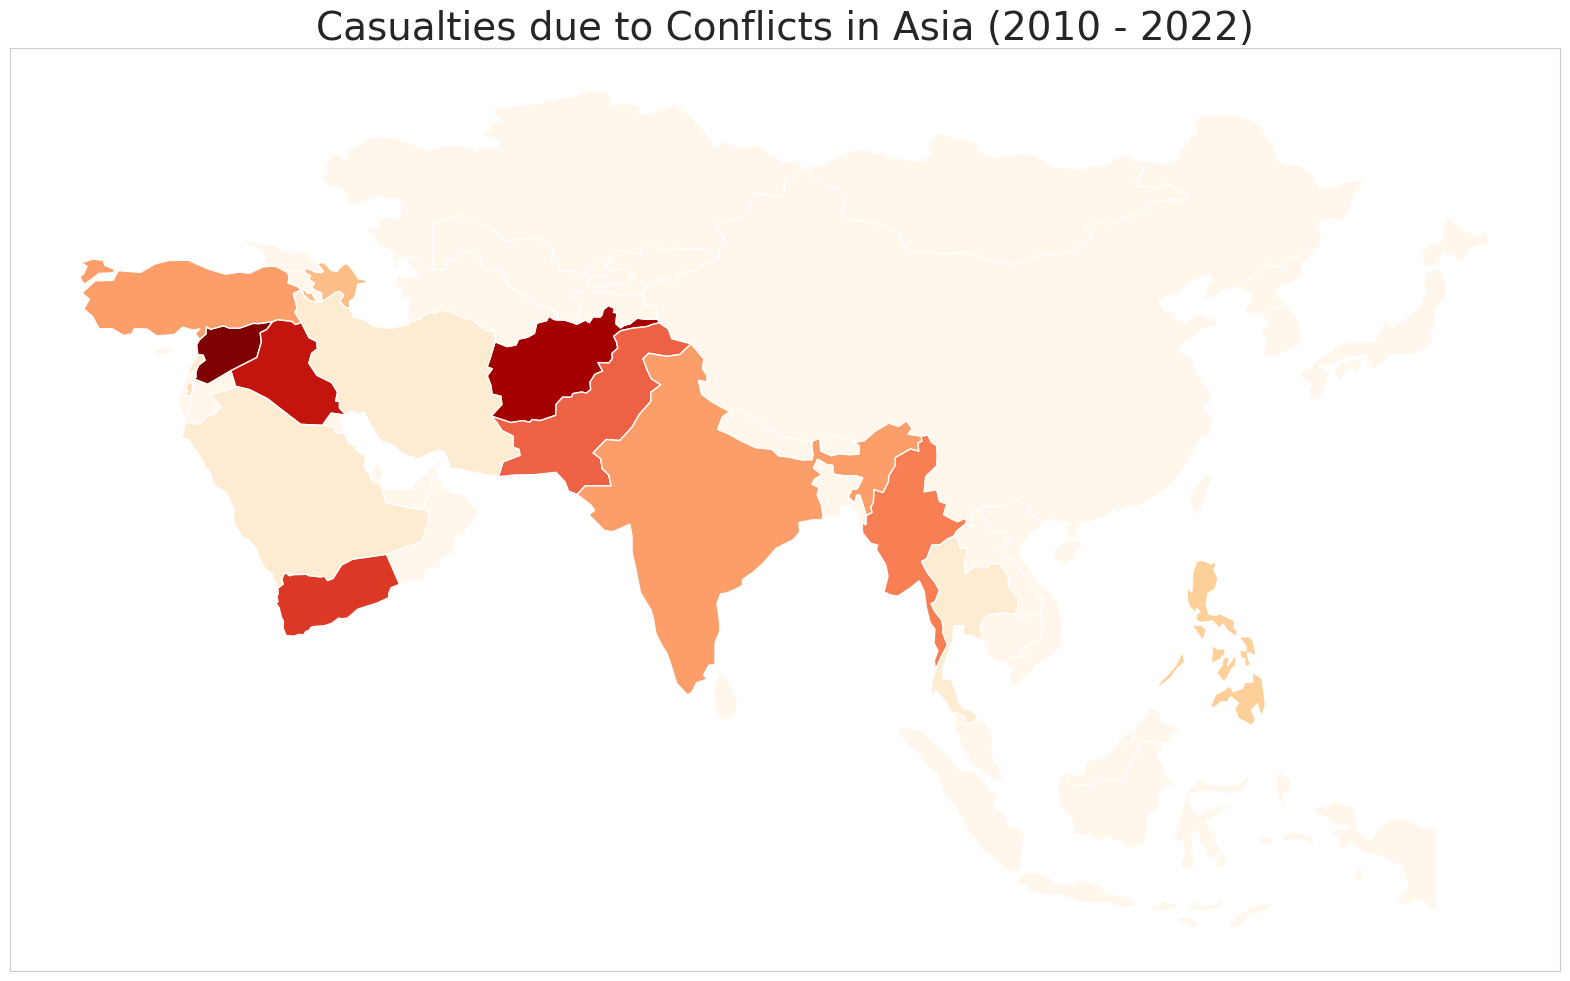

In [267]:
plot_global_casualties(2010, 2022, "Asia")

/tmp/ipykernel_547597/309742030.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


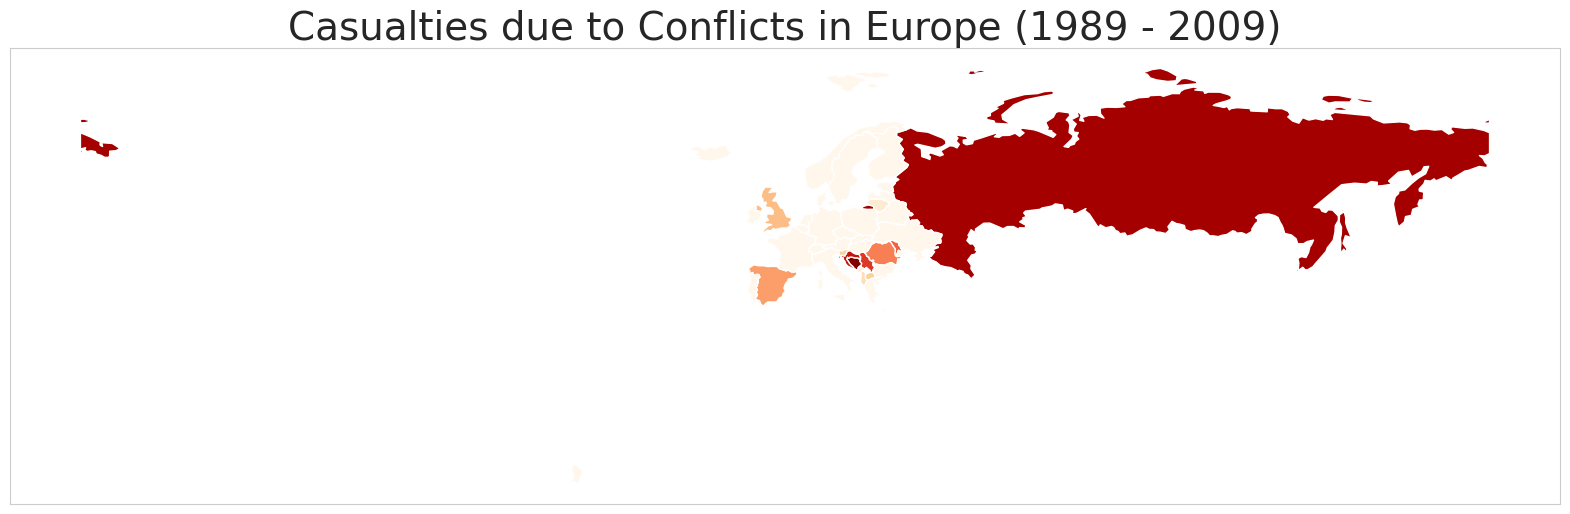

In [268]:
plot_global_casualties(1989, 2009, "Europe")

/tmp/ipykernel_547597/309742030.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
/home/tobetek/.local/lib/python3.10/site-packages/mapclassify/classifiers.py:686: UserWarning: Not enough unique values in array to form 12 classes. Setting k to 11.
  self._classify()


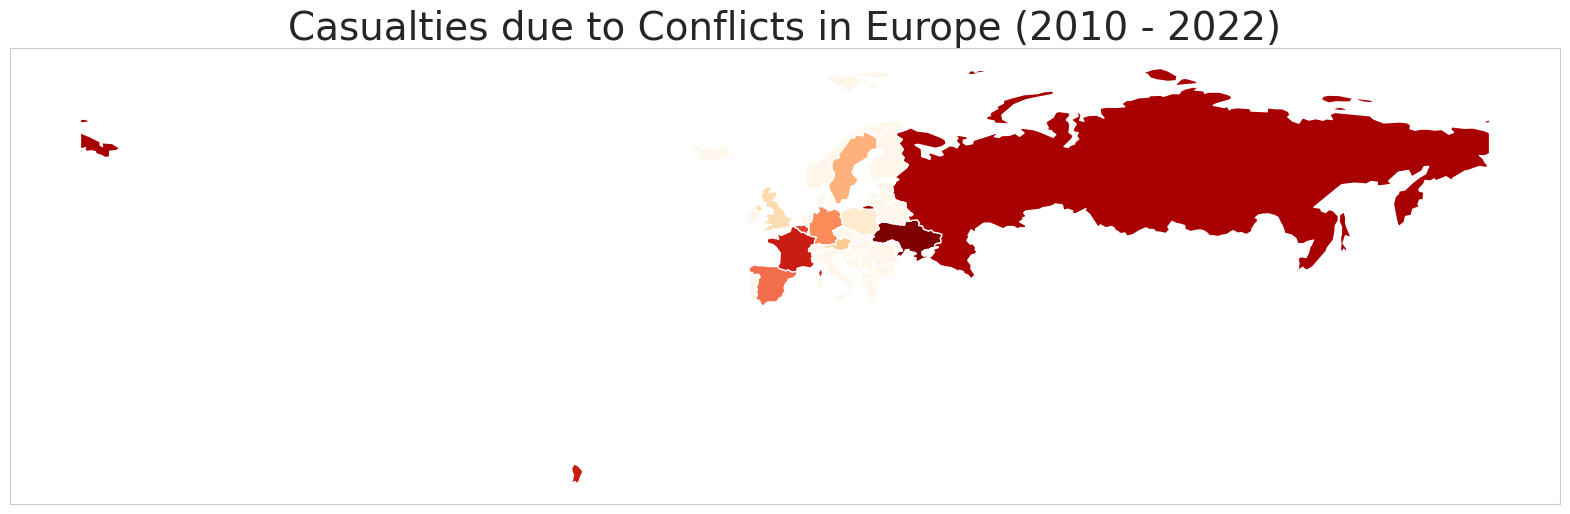

In [269]:
plot_global_casualties(2010, 2022, "Europe")

/tmp/ipykernel_547597/309742030.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


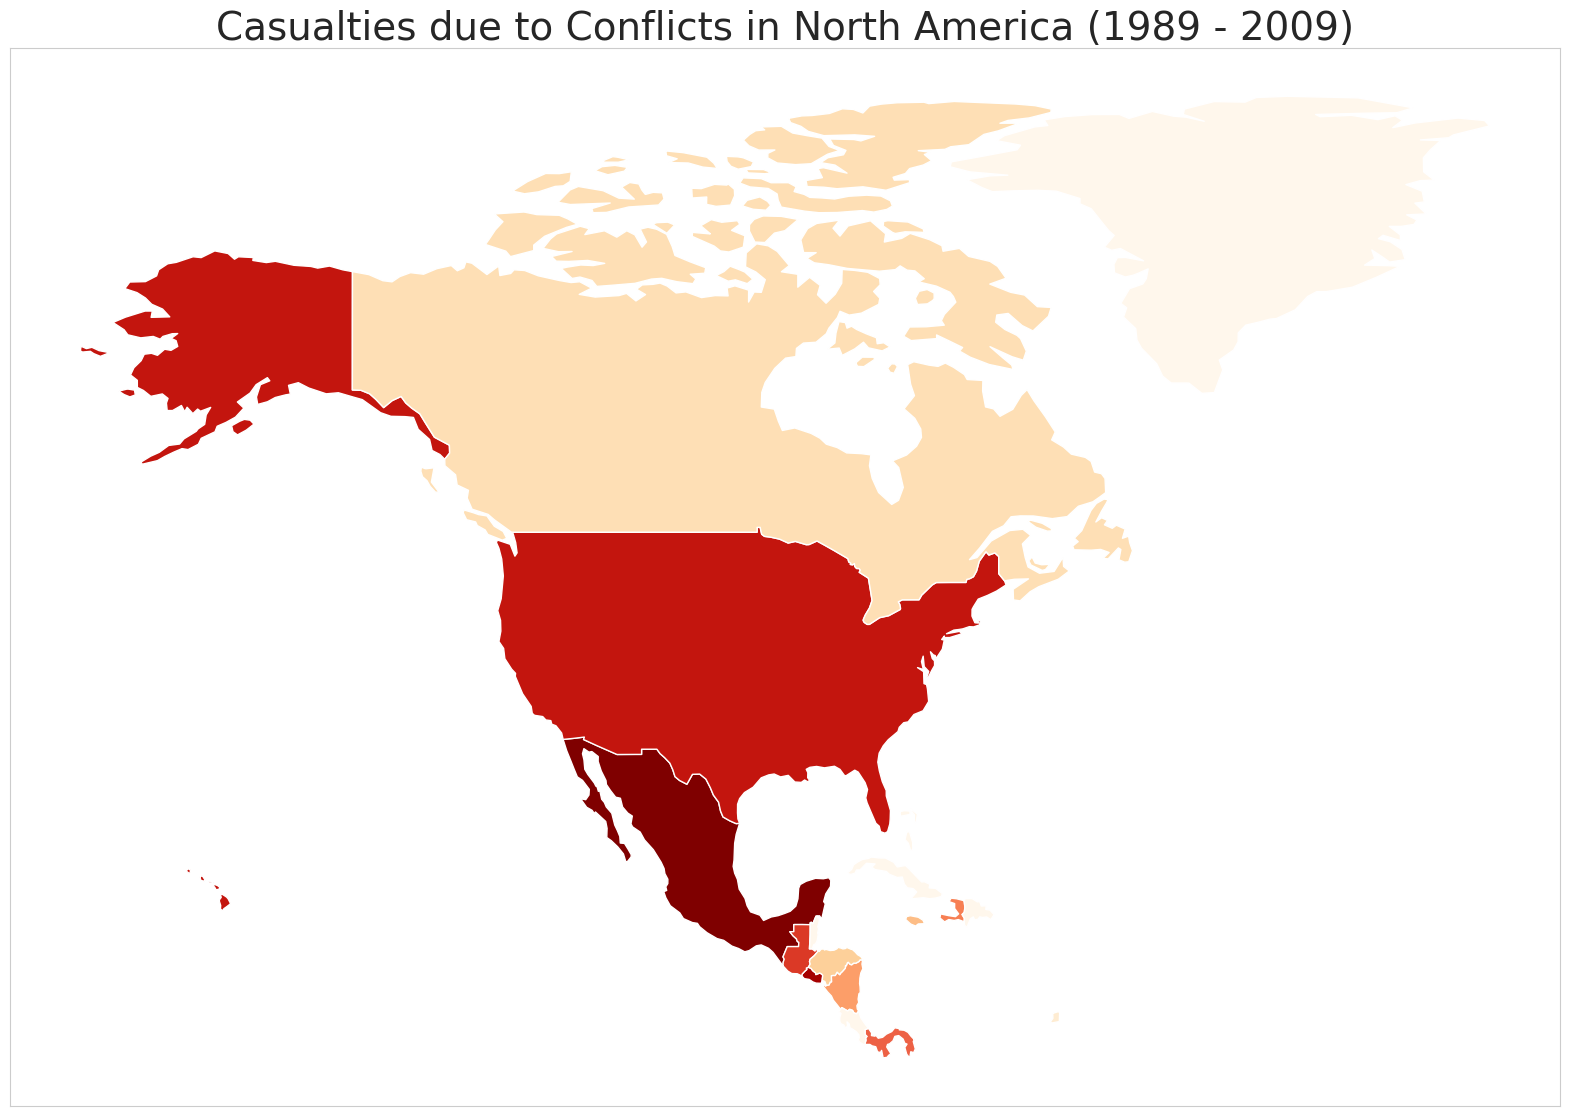

In [270]:
plot_global_casualties(1989, 2009, "North America")

/tmp/ipykernel_547597/309742030.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
/home/tobetek/.local/lib/python3.10/site-packages/mapclassify/classifiers.py:686: UserWarning: Not enough unique values in array to form 12 classes. Setting k to 7.
  self._classify()


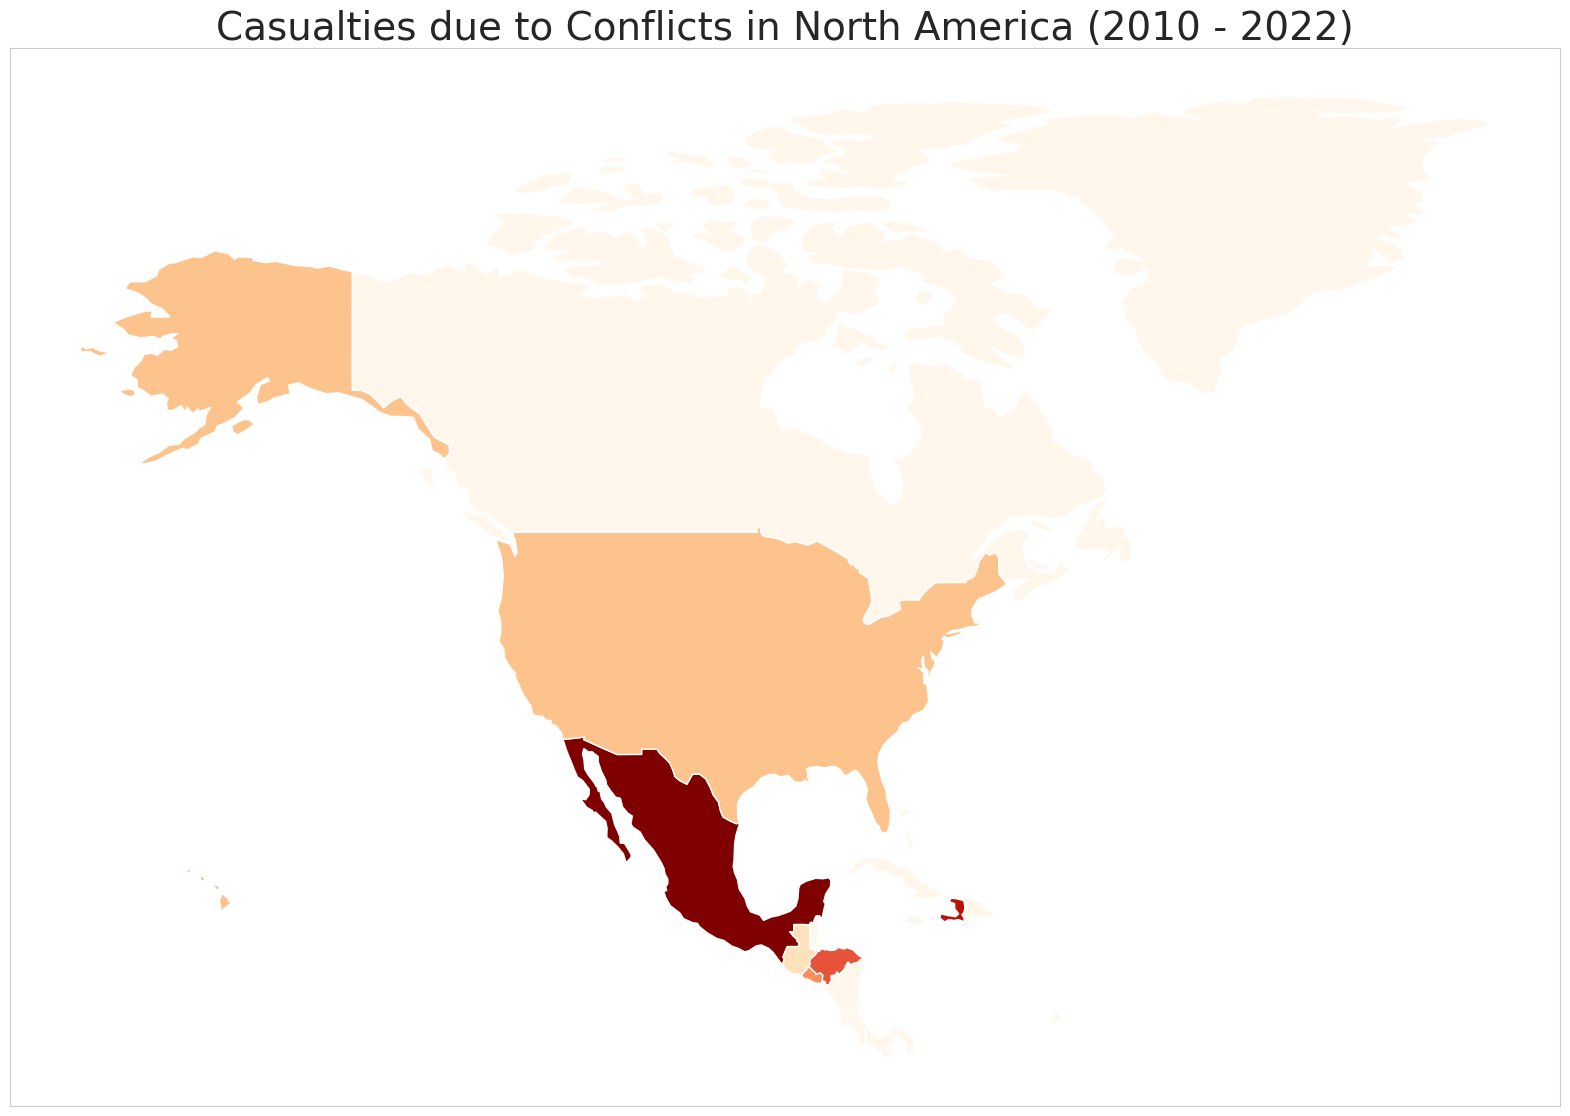

In [271]:
plot_global_casualties(2010, 2022, "North America")

/tmp/ipykernel_547597/309742030.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
/home/tobetek/.local/lib/python3.10/site-packages/mapclassify/classifiers.py:686: UserWarning: Not enough unique values in array to form 12 classes. Setting k to 10.
  self._classify()


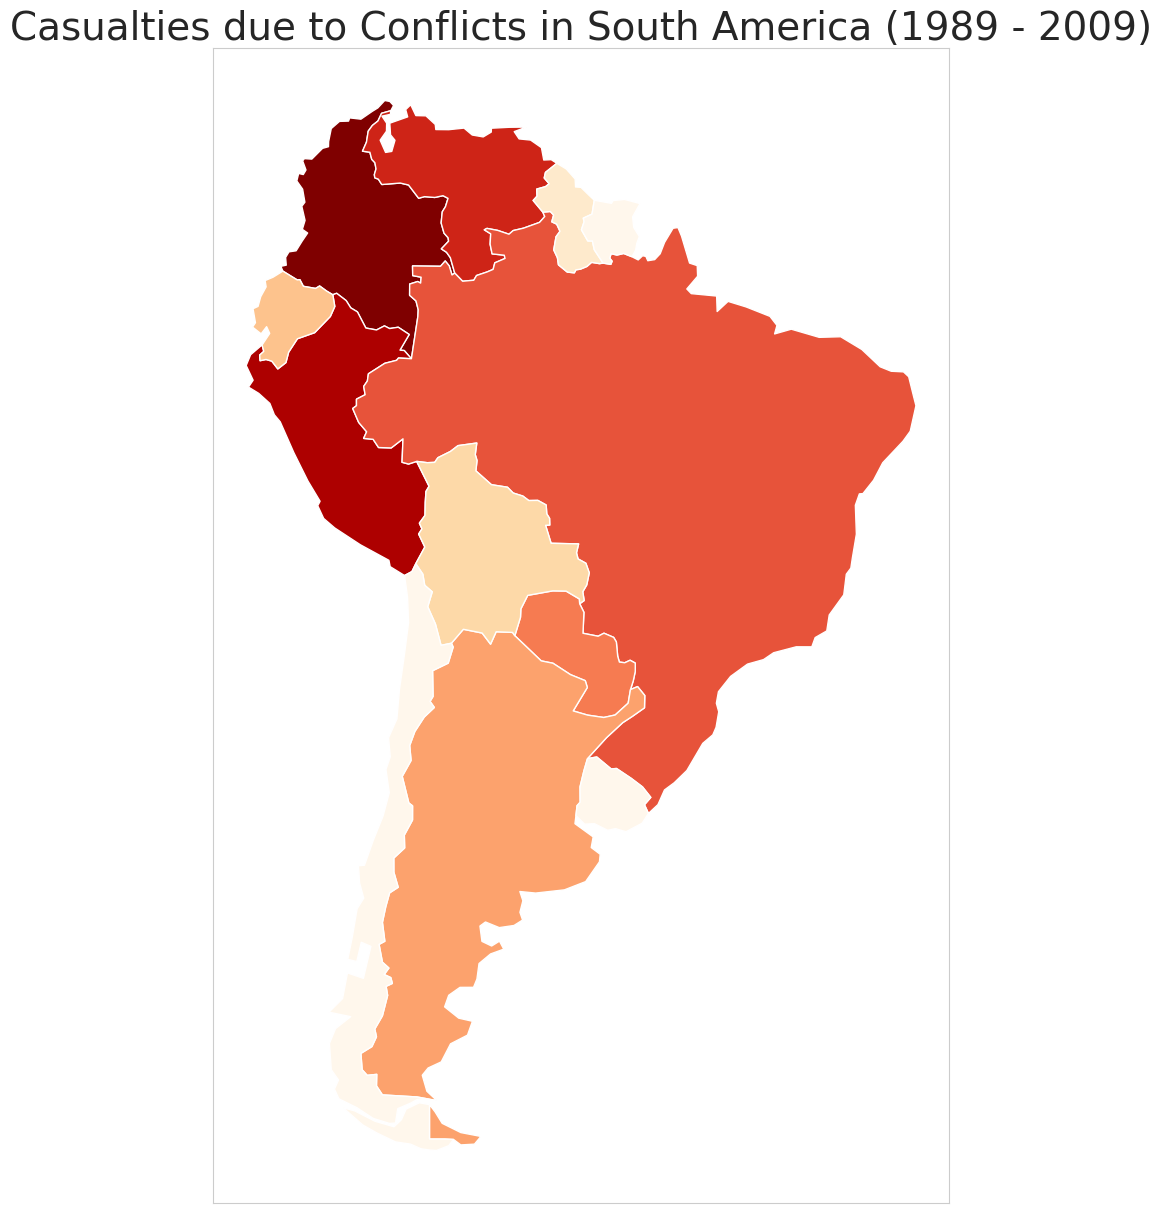

In [272]:
plot_global_casualties(1989, 2009, "South America")

/tmp/ipykernel_547597/309742030.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
/home/tobetek/.local/lib/python3.10/site-packages/mapclassify/classifiers.py:686: UserWarning: Not enough unique values in array to form 12 classes. Setting k to 7.
  self._classify()


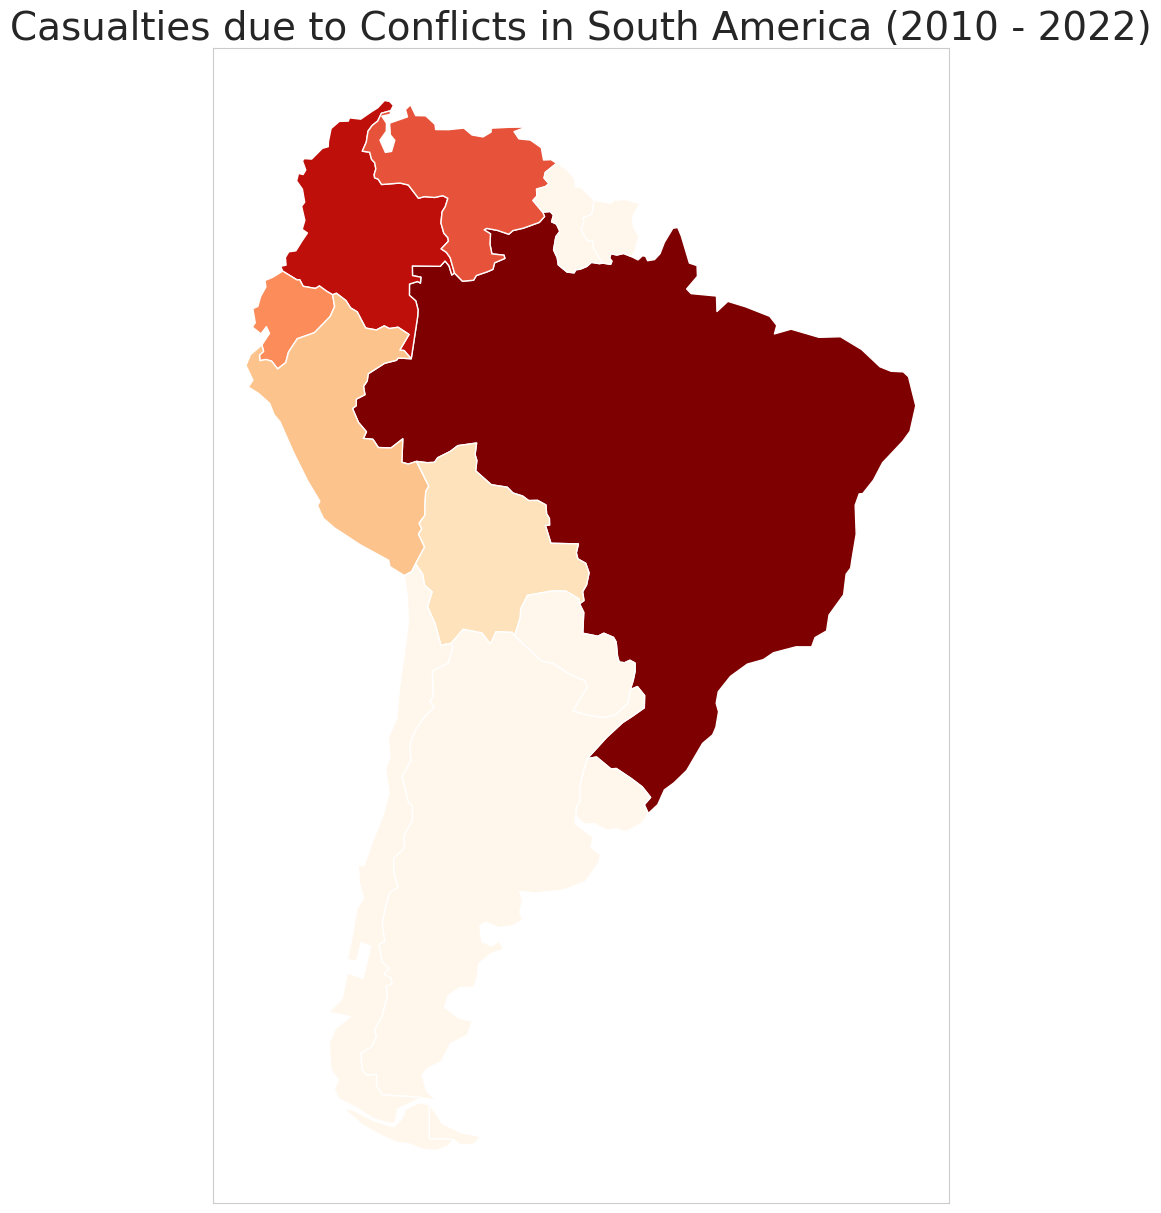

In [273]:
plot_global_casualties(2010, 2022, "South America")

/tmp/ipykernel_547597/309742030.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
/home/tobetek/.local/lib/python3.10/site-packages/mapclassify/classifiers.py:686: UserWarning: Not enough unique values in array to form 12 classes. Setting k to 3.
  self._classify()


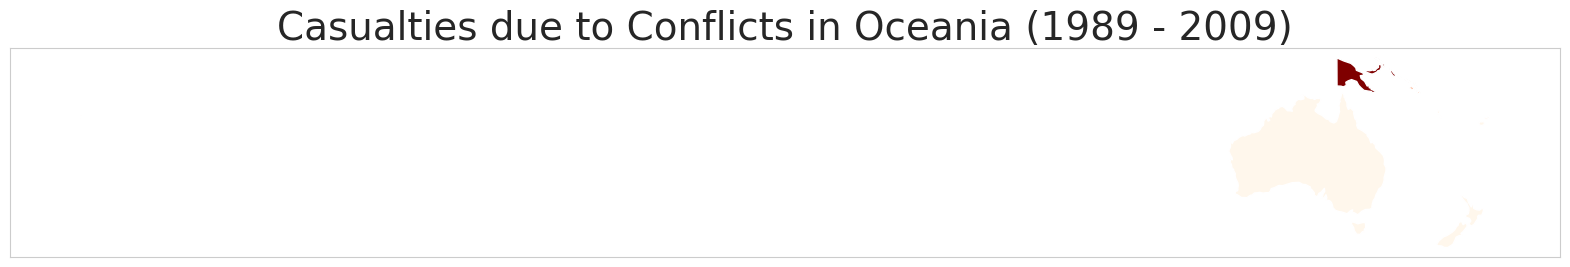

In [274]:
plot_global_casualties(1989, 2009, "Oceania")

/tmp/ipykernel_547597/309742030.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
/home/tobetek/.local/lib/python3.10/site-packages/mapclassify/classifiers.py:686: UserWarning: Not enough unique values in array to form 12 classes. Setting k to 3.
  self._classify()


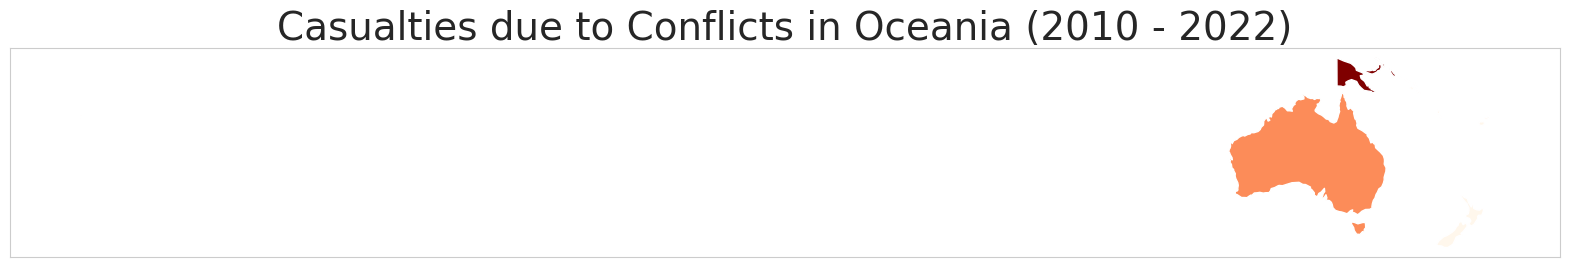

In [275]:
plot_global_casualties(2010, 2022, "Oceania")